# Imports

NumPy will be used for almost everything, but also import a few other libraries to read the data and make visualizations.

#### MNIST Dataset
Images of size 28x28 and 1 channel because they are grayscale images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Load CSVs
train_df = pd.read_csv("fashion-mnist_train.csv")
test_df  = pd.read_csv("fashion-mnist_test.csv")

# Check data is complete
print("Train rows:", len(train_df))
print("Train cols:", len(train_df.columns))
print("Test rows:", len(test_df))
print("Test cols:", len(test_df.columns))

# Extract labels and features
y_train = train_df.iloc[:, 0].to_numpy()
X_train = train_df.iloc[:, 1:].to_numpy()
X_test  = test_df.to_numpy()

# Normalize pixel values to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape)


Train rows: 60000
Train cols: 785
Test rows: 10000
Test cols: 785
Training set: (60000, 784) (60000,)
Test set: (10000, 785)


Unique labels: [0 1 2 3 4 5 6 7 8 9]
Number of samples per label:
Class 0: 6000 samples
Class 1: 6000 samples
Class 2: 6000 samples
Class 3: 6000 samples
Class 4: 6000 samples
Class 5: 6000 samples
Class 6: 6000 samples
Class 7: 6000 samples
Class 8: 6000 samples
Class 9: 6000 samples


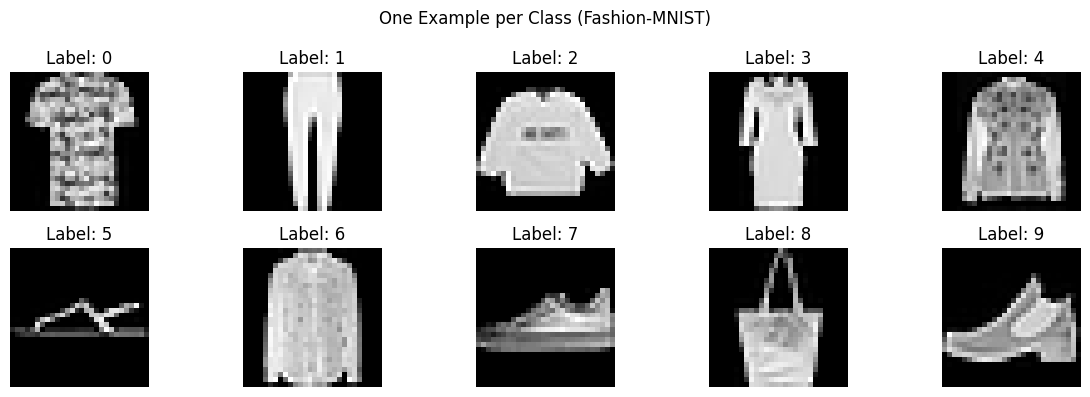

In [2]:
# dataset info
print("Unique labels:", np.unique(y_train))
print("Number of samples per label:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

# Plot one sample per label
plt.figure(figsize=(12, 4))
for label in range(10):
    idx = np.where(y_train == label)[0][0] 
    img = X_train[idx].reshape(28, 28)
    
    plt.subplot(2, 5, label + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.suptitle("One Example per Class (Fashion-MNIST)")
plt.tight_layout()
plt.show()


In [3]:

# Train / Validation Split
split_ratio = 0.9
n_total = len(X_train)
split_idx = int(n_total * split_ratio)

# make it random
perm = np.random.permutation(n_total)
X_train, y_train = X_train[perm], y_train[perm]

# split
X_val = X_train[split_idx:]
y_val = y_train[split_idx:]
X_train = X_train[:split_idx]
y_train = y_train[:split_idx]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


Train set: (54000, 784), (54000,)
Validation set: (6000, 784), (6000,)


# One-Hot Encoding for Labels
The output layer of the network consists of 10 neurons, each representing one of the ten possible numbers. To ensure consistency in dimensionality across labels in the dataset and facilitate calculations of loss and other metrics, I will one-hot encode the labels. This will generate an array of length 10 for each label, where all elements are set to 0 except for the index corresponding to the label. 

In [5]:
y_train_samples = y_train[:10]
y_val_samples = y_val[:10]

num_classes = len(np.unique(y_train))
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]


y_train_onehot_samples = y_train[:10]
for y, y_onehot in zip(y_train_samples, y_train_onehot_samples):
    print(f"Original label: {y} | One-hot encoded label: {y_onehot}")
print('--------------------------------------------------------------')
y_val_onehot_samples = y_val[:10]
for y, y_onehot_val in zip(y_val_samples, y_val_onehot_samples):
    print(f"Original label: {y} | One-hot encoded label: {y_onehot_val}")

Original label: 4 | One-hot encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original label: 5 | One-hot encoded label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Original label: 4 | One-hot encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original label: 8 | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Original label: 9 | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Original label: 3 | One-hot encoded label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Original label: 4 | One-hot encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original label: 2 | One-hot encoded label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original label: 3 | One-hot encoded label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Original label: 5 | One-hot encoded label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
--------------------------------------------------------------
Original label: 8 | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Original label: 7 | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original label: 0 | One-hot encoded l

# Creating a Dataloader
I've implemented a generator functions that returns a batch of data. 

Batch X shape: (64, 784) Batch y shape: (64, 10)
Labels in this batch: [0. 1.]


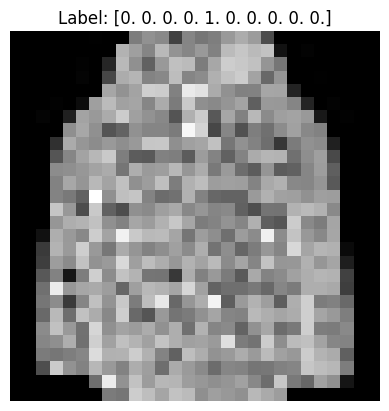

In [6]:
def get_batch(X, y, batch_size):
    n_batches = X.shape[0] // batch_size
    for i in range(n_batches):
        X_batch = X[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield X_batch, y_batch

# Try function
batch_size = 64
for Xb, yb in get_batch(X_train, y_train, batch_size):
    print("Batch X shape:", Xb.shape, "Batch y shape:", yb.shape)
    print("Labels in this batch:", np.unique(yb))
    # Show the first image of this batch
    plt.imshow(Xb[0].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {yb[0]}")
    plt.axis('off')
    plt.show()
    break  # remove this to loop through all batches




Add random shufling per epoch, as we will need that to train a network with randomized batches each epoch, so digits are not seen in order.

Batch: (128, 784) (128, 10)
Labels in this batch: [0. 1.]


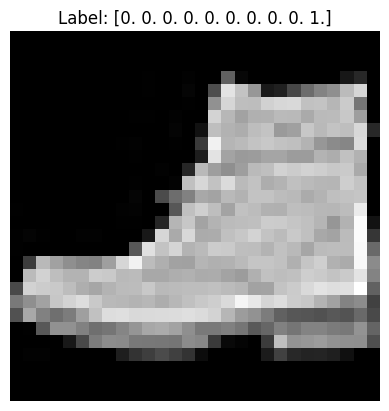

In [7]:
def get_batch(X, y, batch_size, shuffle=True):
    idx = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, X.shape[0] - batch_size + 1, batch_size):
        batch_idx = idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

# Test function -> when run multiple times, output changes (above never changes)
batch_size = 128
for Xb, yb in get_batch(X_train, y_train, batch_size, shuffle=True): # set shuffle to True
    print("Batch:", Xb.shape, yb.shape)
    print("Labels in this batch:", np.unique(yb))
    # Show the first image of this batch
    plt.imshow(Xb[0].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {yb[0]}")
    plt.axis('off')
    plt.show()
    break  # remove this to loop through all batches




# Activation Functions
Activation functions are mathematical functions applied to the output of each neuron in a neural network's hidden layers. They introduce non-linearity to the network, enabling it to learn complex patterns in data. Without activation functions, neural networks would essentially reduce to linear transformations, which limits their ability to learn complex relationships in data.

I've used two different activations functions in my network architecture, Rectified Linear Unit (ReLU) and SoftMax. The former is used in the hidden layer, and the latter is applied to the output layer. 

ReLU sets all negative values to zero and leaves positive values unchanged. For a given input x, is defined as
$$
ReLU(x) = max(0,x)
$$

SoftMax is commonly used in the output layer of a neural network. It converts the raw output scores into probabilities, ensuring that the sum of the probabilities across all classes equals one. It is defined as
$$
p_i = \frac{e^{z_i}}{\sum e^{z_j}}
$$



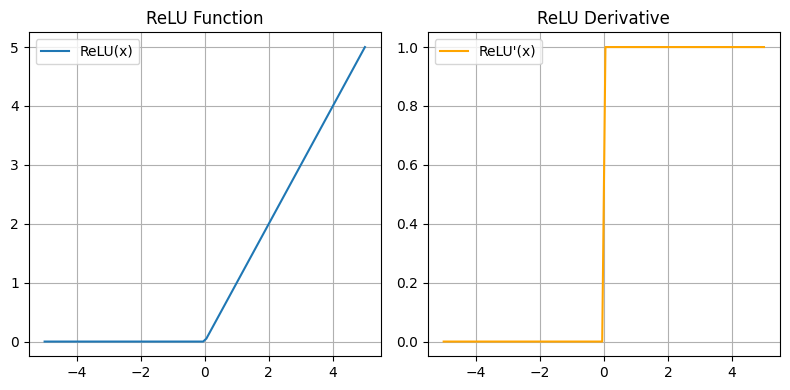

Softmax output:
 [[0.63806635 0.23473149 0.0954347  0.03176745]
 [0.11035682 0.81543273 0.04958652 0.02462393]
 [0.10189196 0.08342208 0.75288537 0.06180059]]
Row sums (should be 1): [1. 1. 1.]


In [8]:
# ReLU
def relu(x):
    return np.maximum(x, 0)

# ReLU derivative for backpropagation
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# SoftMax
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Test ReLUs
x = np.linspace(-5, 5, 100) # Input range

# Apply ReLU and its derivative
y = relu(x)
dy = relu_derivative(x)

# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x, y, label='ReLU(x)')
plt.title("ReLU Function")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(x, dy, color='orange', label="ReLU'(x)")
plt.title("ReLU Derivative")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Test SoftMax
logits = np.array([
    [2.0, 1.0, 0.1, -1.0],
    [1.0, 3.0, 0.2, -0.5],
    [0.5, 0.3, 2.5, 0.0]
]) # Input logits for 3 samples × 4 classes

probs = softmax(logits)
print("Softmax output:\n", probs)
print("Row sums (should be 1):", np.sum(probs, axis=1))


# Forward Pass

This image explains the mathematical operations involved in forward and backward pass.

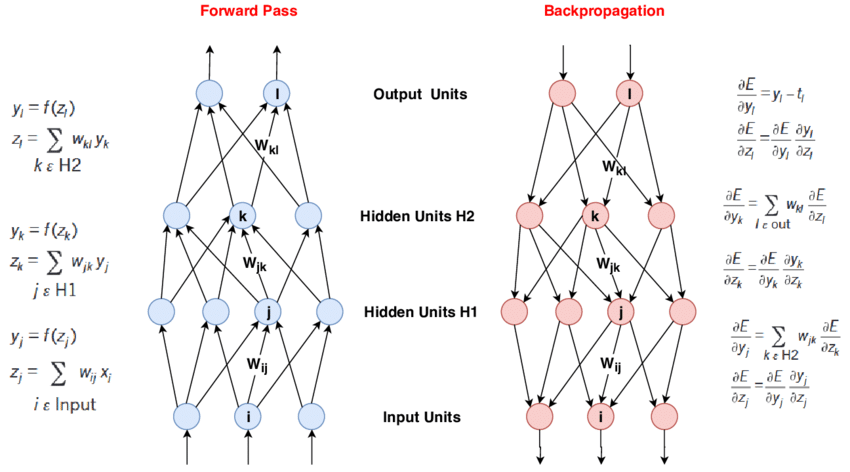

##### Input and Hidden Layer

Starting from the bottom, we have the input values, so the flattened input images denoted as $x=a^0$. 
\
We also have the weights that connect the input layer to the first and only hidden layer $w^1$, as well as the bias of the hidden layer $b^1$. Then, we calculate the first weighted sum $z^1$ as
$$
a^0 = x
$$
$$
z^1 = w^1*a^0 + b^1
$$ 
The weighted sum is passed through an activation function
$$
a^1 = f(z^1) = ReLU(z^1)
$$

##### Hidden and Output Layer

The output from the activation function of the hidden layer is used as input for the next layer and it repeats as many times as layers in the network.
$$
z^2 = w^2a^1+b^2
$$
$$
a^2 = SoftMax(z^2)
$$
The output layer is special, as the SoftMax function is applied. Therefore, the output of this activation function $a^2$ is the prediction of the network, usually denoted as $\hat{y}$.


In [9]:
# For 2 layers network
def forward(X, W1, b1, W2, b2):
    z1 = X @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

# Test forward pass
X_sample = np.random.rand(5, 784)  # 5 samples, 784 features

# Layer sizes
input_size = 784
hidden_size = 128
output_size = 10

# initial weights & biases
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

# Forward pass
z1, a1, z2, a2 = forward(X_sample, W1, b1, W2, b2)

print("z1 shape:", z1.shape)
print("a1 shape:", a1.shape)
print("z2 shape:", z2.shape)
print("a2 shape:", a2.shape)
print("Row sums of a2 (should be 1):", np.sum(a2, axis=1))


z1 shape: (5, 128)
a1 shape: (5, 128)
z2 shape: (5, 10)
a2 shape: (5, 10)
Row sums of a2 (should be 1): [1. 1. 1. 1. 1.]


But now, we want to make it flexible, so the user can choose the number of hidden layers, as well as the number of hiden units per layer by setting that up in a list.

Then, weights and biases will be stored in lists to loop them dynamically.

In [ ]:

# Loop over the sizes of the network that are send in a list
def init_network(layer_sizes):
    """
    layer_sizes: list of layer sizes that form network including input and output.
    Example: [784, 128, 64, 10] = input -> 128 -> 64 -> output
    With this list, I am defining both: 
    - number of hidden layers (lenght of list)
    - number of hidden units (numbers in list)
    """
    params = []
    for i in range(len(layer_sizes) - 1):
        W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i])
        b = np.zeros((1, layer_sizes[i+1]))
        params.append((W, b))
    return params

# Forward pass
def forward_flexible(X, params):
    """
    params: list of (W, b) tuples for each layer
    Returns: (activations, pre_activations)
    """
    activations = [X]
    pre_activations = []
    
    for i, (W, b) in enumerate(params):
        z = activations[-1] @ W + b
        pre_activations.append(z)
        
        # Apply ReLU for hidden layers, Softmax for last
        if i < len(params) - 1:
            a = relu(z)
        else:
            a = softmax(z)
        activations.append(a)
        
    return pre_activations, activations


# Test it
# Architecture: input → 128 → 64 → output(10)
layer_sizes = [784, 128, 82, 64, 10]
params = init_network(layer_sizes)

# Forward pass
X_sample = np.random.rand(5, 784)
pre_acts, acts = forward_flexible(X_sample, params)

for i, (z, a) in enumerate(zip(pre_acts, acts[1:])):
    print(f"Layer {i+1}: z.shape={z.shape}, a.shape={a.shape}")


Layer 1: z.shape=(5, 128), a.shape=(5, 128)
Layer 2: z.shape=(5, 82), a.shape=(5, 82)
Layer 3: z.shape=(5, 64), a.shape=(5, 64)
Layer 4: z.shape=(5, 10), a.shape=(5, 10)


# Optimizers
Implement SGD, Adam and Momentum Optimizers.

In [11]:
def init_optimizer_states(params, optimizer='sgd'):
    """Initialize optimizer-specific states."""
    if optimizer == 'momentum':
        v = [ (np.zeros_like(W), np.zeros_like(b)) for W, b in params ]
        return {'v': v}
    elif optimizer == 'adam':
        m = [ (np.zeros_like(W), np.zeros_like(b)) for W, b in params ]
        v = [ (np.zeros_like(W), np.zeros_like(b)) for W, b in params ]
        return {'m': m, 'v': v, 't': 0}
    else:
        return {}  # SGD has no state


# Update Parameters
To update the parameters, i.e. the weights and biases, we first need to define a learning rate $\alpha$. 
\
The learning rate is a hyperparameter that determines the step size at which the model's parameters are updated during the training process. We'll use the optimization algorithms gradient descent to minimize the loss function. The learning rate controls the size of the steps taken in the direction opposite to the gradient of the loss function. Defined as
$$
\theta_{new} = \theta_{old} - \alpha*C
$$



In [12]:
# For 2 layers network

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2


# Flexible network
def update_parameters_flexible(params, grads, learning_rate, optimizer='sgd', opt_state=None, beta1=0.9, beta2=0.999, eps=1e-8, momentum=0.9):
    """Update parameters according to selected optimizer."""
    new_params = []

    if optimizer == 'sgd':
        for (W, b), (dW, db) in zip(params, grads):
            W -= learning_rate * dW
            b -= learning_rate * db
            new_params.append((W, b))

    elif optimizer == 'momentum':
        for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
            vW, vb = opt_state['v'][i]
            vW = momentum * vW - learning_rate * dW
            vb = momentum * vb - learning_rate * db
            W += vW
            b += vb
            new_params.append((W, b))
            opt_state['v'][i] = (vW, vb)

    elif optimizer == 'adam':
        opt_state['t'] += 1
        t = opt_state['t']

        for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
            mW, mb = opt_state['m'][i]
            vW, vb = opt_state['v'][i]

            # Update biased first moment estimate
            mW = beta1 * mW + (1 - beta1) * dW
            mb = beta1 * mb + (1 - beta1) * db
            # Update biased second raw moment estimate
            vW = beta2 * vW + (1 - beta2) * (dW ** 2)
            vb = beta2 * vb + (1 - beta2) * (db ** 2)
            # Bias correction
            mW_hat = mW / (1 - beta1 ** t)
            mb_hat = mb / (1 - beta1 ** t)
            vW_hat = vW / (1 - beta2 ** t)
            vb_hat = vb / (1 - beta2 ** t)
            # Update parameters
            W -= learning_rate * mW_hat / (np.sqrt(vW_hat) + eps)
            b -= learning_rate * mb_hat / (np.sqrt(vb_hat) + eps)

            opt_state['m'][i] = (mW, mb)
            opt_state['v'][i] = (vW, vb)
            new_params.append((W, b))

    return new_params, opt_state


# Weight Initialization
While it's possible to start training with random weights and biases, it is generally a good idea to use a better method to set the initial parameter values as it leads to faster convergence.

Different types can be implemented: \
    - He Initialization: better for ReLU activations
    $$
    std = \sqrt{2/n_{in}}
    $$
    - Xavier Initialization: better for tanh/sigmoid activations
    $$
    std = \sqrt{1/n_{in}}
    $$

In [ ]:
# for a flexible network and lets chose between the 2 methods
def init_weights_flexible(layer_sizes, method='he'):
    """
    layer_sizes: list of layer sizes, e.g. [784, 128, 64, 10]
    method: 'he' or 'xavier'
    
    Returns:
        params: list of (W, b) pairs
    """
    params = []
    for i in range(len(layer_sizes) - 1):
        in_dim = layer_sizes[i]
        out_dim = layer_sizes[i + 1]

        if method.lower() == 'he':
            scale = np.sqrt(2. / in_dim)
        elif method.lower() == 'xavier':
            scale = np.sqrt(1. / in_dim)
        else:
            raise ValueError("Unknown initialization method. Use 'he' or 'xavier'.")

        W = np.random.randn(in_dim, out_dim) * scale
        b = np.zeros((1, out_dim))
        params.append((W, b))

    return params

# Test it
# He initialization
params_he = init_weights_flexible([784, 128, 64, 10], method='he')

# Xavier initialization
params_xavier = init_weights_flexible([784, 128, 64, 10], method='xavier')

# Check layer shapes
for i, (W, b) in enumerate(params_he):
    print(f"Layer {i+1}: W shape {W.shape}, b shape {b.shape}")

print('------------------------------------')

for i, (W, b) in enumerate(params_xavier):
    print(f"Layer {i+1}: W shape {W.shape}, b shape {b.shape}")



Layer 1: W shape (784, 128), b shape (1, 128)
Layer 2: W shape (128, 64), b shape (1, 64)
Layer 3: W shape (64, 10), b shape (1, 10)
------------------------------------
Layer 1: W shape (784, 128), b shape (1, 128)
Layer 2: W shape (128, 64), b shape (1, 64)
Layer 3: W shape (64, 10), b shape (1, 10)


# Loss functions

In the previous section, we calculated the output $a^2 = \hat{y}$. This value alongside the ground truth label $y$ is run through a loss function. 
\
Ideally, at each iteration the value of the loss function should decrease, indicating the model's improving ability to learn. There are multiple options to use.

\
The Mean Squared Error function (MSE) is defined as
$$
Loss = \frac{1}{2}(a_k-y_k)^2
$$

The Cross Entropy Loss defines as
$$
Loss = -\sum y_k log(a_k)
$$

We will also get the gradients of the loss functions needed for backpropagation.


In [4]:
# ---------- Loss Functions ----------
def mean_squared_error(y_true, y_pred):
    """Mean Squared Error (for regression)"""
    loss = np.mean(np.sum((y_true - y_pred) ** 2, axis=1) / 2.0)
    dA = (y_pred - y_true) / y_true.shape[0]
    return loss, dA

def cross_entropy_loss(y_true, y_pred, eps=1e-12):
    """Categorical Cross-Entropy (for one-hot labels)"""
    y_pred_clipped = np.clip(y_pred, eps, 1 - eps)
    loss = -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))
    dA = (y_pred - y_true) / y_true.shape[0]
    return loss, dA

    

# Test it
y_true = np.eye(10)[np.array([3, 1, 4, 0])]   # one-hot labels
y_pred = np.random.rand(4, 10)
y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)  # softmax normalize


# Compute loss and gradient
loss, dA = cross_entropy_loss(y_true, y_pred)
print("Loss:", loss)
print("dA shape:", dA.shape)


Loss: 2.4329962570632553
dA shape: (4, 10)


# Accuracy Function

In [15]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# Test it
acc = accuracy(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.0


# Backward Pass

To calculate the changes that we need to make to the network parameters, we need to calculate the gradients of the network.  This is called backpropagation.

But we want to make it flexible, so the user can choose the number of hidden layers, as well as the number of hiden units per layer by setting that up in a list.

Then, weights and biases will be stored in lists to loop them dynamically.

The pass gets the dA from the Loss Function as a parameter of the function.

In [ ]:
def backward_flexible(X, y, params, pre_acts, acts, dA_last=None):
    """
    Compute backward pass for arbitrary number of layers.
    X: input data (batch)
    y: one-hot encoded labels
    params: list of (W, b) pairs
    pre_acts: list of z values from forward pass
    acts: list of activations (len = len(params)+1)
    Returns: list of (dW, db) pairs
    """
    grads = [None] * len(params)
    m = X.shape[0]
    
    # --- Output layer gradient -> dA from loss functions ---
    delta = dA_last if dA_last is not None else (acts[-1] - y)
    grads[-1] = (
        acts[-2].T @ delta / m,
        np.sum(delta, axis=0, keepdims=True) / m
    )
    
    # --- Backprop through hidden layers ---
    for l in reversed(range(len(params) - 1)):
        W_next, _ = params[l + 1]
        z = pre_acts[l]
        delta = (delta @ W_next.T) * relu_derivative(z)
        dW = acts[l].T @ delta / m
        db = np.sum(delta, axis=0, keepdims=True) / m
        grads[l] = (dW, db)
    
    return grads

# Try it
layer_sizes = [784, 128, 64, 10]
params = init_network(layer_sizes)

# forward
X_sample = np.random.rand(5, 784)
y_sample = np.eye(10)[np.random.randint(0, 10, size=5)]  # one-hot labels
pre_acts, acts = forward_flexible(X_sample, params)

# backward
grads = backward_flexible(X_sample, y_sample, params, pre_acts, acts)

# dimensions
for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
    print(f"Layer {i+1}: W {W.shape}, dW {dW.shape}, b {b.shape}, db {db.shape}")


Layer 1: W (784, 128), dW (784, 128), b (1, 128), db (1, 128)
Layer 2: W (128, 64), dW (128, 64), b (1, 64), db (1, 64)
Layer 3: W (64, 10), dW (64, 10), b (1, 10), db (1, 10)


# Training Loop
A simple training loop that executes the previous function for forward and backward pass. Additionally, I have previously defined a function to get batches of data for training. I will use mini-batch gradient descent to update the weights and biases for each batch.

Furthermore, I have created a dictionary to collect accuracies and losses at each step. This will enable us to monitor the model's learning progress throughout training, and I will visualize the results at the end.


In [ ]:
def train(
    X_train, y_train,
    X_val=None, y_val=None,
    layer_sizes=[784, 128, 64, 10],
    epochs=10,
    batch_size=64,
    learning_rate=0.01,
    init_method='he',
    loss_name='cross_entropy',
    optimizer='sgd',        
    momentum=0.9           
):
    # Initialize weights
    params = init_weights_flexible(layer_sizes, method=init_method)
    loss_fn = get_loss_function(loss_name)
    opt_state = init_optimizer_states(params, optimizer)

    # Training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size

    for epoch in range(epochs):
        perm = np.random.permutation(n_samples)
        X_train = X_train[perm]
        y_train = y_train[perm]

        epoch_loss, epoch_acc = 0, 0

        for i in tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{epochs}"):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train[start:end]

            # Forward
            pre_acts, acts = forward_flexible(X_batch, params)
            y_pred = acts[-1]

            # Loss and accuracy
            loss, dA = loss_fn(y_batch, y_pred)
            acc = accuracy(y_batch, y_pred)

            # Backward
            grads = backward_flexible(X_batch, y_batch, params, pre_acts, acts, dA_last=dA)

            # Update parameters
            params, opt_state = update_parameters_flexible(
                params, grads, learning_rate,
                optimizer=optimizer, opt_state=opt_state, momentum=momentum
            )

            epoch_loss += loss
            epoch_acc += acc

        # Epoch metrics
        avg_loss = epoch_loss / n_batches
        avg_acc = epoch_acc / n_batches
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(avg_acc)

        # Validation
        if X_val is not None and y_val is not None:
            _, val_acts = forward_flexible(X_val, params)
            y_val_pred = val_acts[-1]
            val_loss, _ = loss_fn(y_val, y_val_pred)
            val_acc = accuracy(y_val, y_val_pred)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, acc={avg_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, acc={avg_acc:.4f}")

    return params, history


# Plotting Function

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot loss and accuracy curves for training and validation"""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # ---- LOSS ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    if history['val_loss']:
        plt.plot(epochs, history['val_loss'], label='Val Loss', marker='x')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # ---- ACCURACY ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    if history['val_acc']:
        plt.plot(epochs, history['val_acc'], label='Val Accuracy', marker='x')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


Epoch 1/150: 100%|██████████| 1687/1687 [00:01<00:00, 931.22it/s]


Epoch 1: loss=0.1741, acc=0.6630, val_loss=0.1235, val_acc=0.7653


Epoch 2/150: 100%|██████████| 1687/1687 [00:01<00:00, 975.53it/s]


Epoch 2: loss=0.1129, acc=0.7841, val_loss=0.1046, val_acc=0.8037


Epoch 3/150: 100%|██████████| 1687/1687 [00:01<00:00, 975.55it/s]


Epoch 3: loss=0.1001, acc=0.8066, val_loss=0.0967, val_acc=0.8175


Epoch 4/150: 100%|██████████| 1687/1687 [00:01<00:00, 851.71it/s] 


Epoch 4: loss=0.0934, acc=0.8175, val_loss=0.0910, val_acc=0.8300


Epoch 5/150: 100%|██████████| 1687/1687 [00:01<00:00, 962.93it/s] 


Epoch 5: loss=0.0890, acc=0.8268, val_loss=0.0879, val_acc=0.8318


Epoch 6/150: 100%|██████████| 1687/1687 [00:01<00:00, 941.62it/s]


Epoch 6: loss=0.0858, acc=0.8299, val_loss=0.0852, val_acc=0.8362


Epoch 7/150: 100%|██████████| 1687/1687 [00:02<00:00, 832.73it/s]


Epoch 7: loss=0.0836, acc=0.8345, val_loss=0.0833, val_acc=0.8392


Epoch 8/150: 100%|██████████| 1687/1687 [00:01<00:00, 936.88it/s] 


Epoch 8: loss=0.0816, acc=0.8380, val_loss=0.0821, val_acc=0.8425


Epoch 9/150: 100%|██████████| 1687/1687 [00:01<00:00, 996.66it/s] 


Epoch 9: loss=0.0801, acc=0.8409, val_loss=0.0806, val_acc=0.8447


Epoch 10/150: 100%|██████████| 1687/1687 [00:01<00:00, 940.01it/s] 


Epoch 10: loss=0.0787, acc=0.8437, val_loss=0.0793, val_acc=0.8450


Epoch 11/150: 100%|██████████| 1687/1687 [00:01<00:00, 947.40it/s] 


Epoch 11: loss=0.0775, acc=0.8456, val_loss=0.0787, val_acc=0.8463


Epoch 12/150: 100%|██████████| 1687/1687 [00:01<00:00, 907.39it/s] 


Epoch 12: loss=0.0764, acc=0.8476, val_loss=0.0778, val_acc=0.8480


Epoch 13/150: 100%|██████████| 1687/1687 [00:02<00:00, 787.91it/s]


Epoch 13: loss=0.0755, acc=0.8504, val_loss=0.0768, val_acc=0.8502


Epoch 14/150: 100%|██████████| 1687/1687 [00:01<00:00, 885.62it/s]


Epoch 14: loss=0.0746, acc=0.8520, val_loss=0.0760, val_acc=0.8517


Epoch 15/150: 100%|██████████| 1687/1687 [00:01<00:00, 921.64it/s] 


Epoch 15: loss=0.0737, acc=0.8538, val_loss=0.0757, val_acc=0.8545


Epoch 16/150: 100%|██████████| 1687/1687 [00:02<00:00, 665.82it/s]


Epoch 16: loss=0.0730, acc=0.8561, val_loss=0.0752, val_acc=0.8528


Epoch 17/150: 100%|██████████| 1687/1687 [00:01<00:00, 872.60it/s] 


Epoch 17: loss=0.0724, acc=0.8565, val_loss=0.0742, val_acc=0.8535


Epoch 18/150: 100%|██████████| 1687/1687 [00:02<00:00, 771.89it/s]


Epoch 18: loss=0.0717, acc=0.8569, val_loss=0.0734, val_acc=0.8547


Epoch 19/150: 100%|██████████| 1687/1687 [00:01<00:00, 971.49it/s] 


Epoch 19: loss=0.0711, acc=0.8582, val_loss=0.0739, val_acc=0.8537


Epoch 20/150: 100%|██████████| 1687/1687 [00:02<00:00, 690.96it/s]


Epoch 20: loss=0.0706, acc=0.8586, val_loss=0.0730, val_acc=0.8592


Epoch 21/150: 100%|██████████| 1687/1687 [00:01<00:00, 846.47it/s]


Epoch 21: loss=0.0700, acc=0.8600, val_loss=0.0737, val_acc=0.8600


Epoch 22/150: 100%|██████████| 1687/1687 [00:02<00:00, 801.58it/s]


Epoch 22: loss=0.0696, acc=0.8617, val_loss=0.0720, val_acc=0.8558


Epoch 23/150: 100%|██████████| 1687/1687 [00:02<00:00, 830.06it/s]


Epoch 23: loss=0.0689, acc=0.8638, val_loss=0.0709, val_acc=0.8575


Epoch 24/150: 100%|██████████| 1687/1687 [00:02<00:00, 682.71it/s]


Epoch 24: loss=0.0684, acc=0.8640, val_loss=0.0716, val_acc=0.8583


Epoch 25/150: 100%|██████████| 1687/1687 [00:01<00:00, 913.14it/s] 


Epoch 25: loss=0.0679, acc=0.8649, val_loss=0.0700, val_acc=0.8617


Epoch 26/150: 100%|██████████| 1687/1687 [00:01<00:00, 876.49it/s]


Epoch 26: loss=0.0676, acc=0.8658, val_loss=0.0704, val_acc=0.8593


Epoch 27/150: 100%|██████████| 1687/1687 [00:02<00:00, 797.14it/s]


Epoch 27: loss=0.0671, acc=0.8670, val_loss=0.0695, val_acc=0.8613


Epoch 28/150: 100%|██████████| 1687/1687 [00:01<00:00, 859.78it/s] 


Epoch 28: loss=0.0666, acc=0.8683, val_loss=0.0697, val_acc=0.8635


Epoch 29/150: 100%|██████████| 1687/1687 [00:01<00:00, 871.07it/s]


Epoch 29: loss=0.0663, acc=0.8695, val_loss=0.0706, val_acc=0.8652


Epoch 30/150: 100%|██████████| 1687/1687 [00:02<00:00, 763.52it/s]


Epoch 30: loss=0.0660, acc=0.8694, val_loss=0.0690, val_acc=0.8612


Epoch 31/150: 100%|██████████| 1687/1687 [00:01<00:00, 865.42it/s] 


Epoch 31: loss=0.0656, acc=0.8698, val_loss=0.0681, val_acc=0.8633


Epoch 32/150: 100%|██████████| 1687/1687 [00:01<00:00, 955.24it/s]


Epoch 32: loss=0.0651, acc=0.8721, val_loss=0.0681, val_acc=0.8670


Epoch 33/150: 100%|██████████| 1687/1687 [00:01<00:00, 921.31it/s] 


Epoch 33: loss=0.0648, acc=0.8720, val_loss=0.0687, val_acc=0.8637


Epoch 34/150: 100%|██████████| 1687/1687 [00:01<00:00, 894.38it/s] 


Epoch 34: loss=0.0645, acc=0.8724, val_loss=0.0673, val_acc=0.8662


Epoch 35/150: 100%|██████████| 1687/1687 [00:01<00:00, 952.26it/s]


Epoch 35: loss=0.0642, acc=0.8734, val_loss=0.0668, val_acc=0.8655


Epoch 36/150: 100%|██████████| 1687/1687 [00:02<00:00, 762.38it/s]


Epoch 36: loss=0.0638, acc=0.8745, val_loss=0.0672, val_acc=0.8650


Epoch 37/150: 100%|██████████| 1687/1687 [00:01<00:00, 918.29it/s] 


Epoch 37: loss=0.0635, acc=0.8749, val_loss=0.0680, val_acc=0.8610


Epoch 38/150: 100%|██████████| 1687/1687 [00:02<00:00, 747.98it/s]


Epoch 38: loss=0.0632, acc=0.8749, val_loss=0.0670, val_acc=0.8660


Epoch 39/150: 100%|██████████| 1687/1687 [00:01<00:00, 928.07it/s]


Epoch 39: loss=0.0629, acc=0.8756, val_loss=0.0666, val_acc=0.8680


Epoch 40/150: 100%|██████████| 1687/1687 [00:01<00:00, 902.75it/s]


Epoch 40: loss=0.0626, acc=0.8768, val_loss=0.0663, val_acc=0.8672


Epoch 41/150: 100%|██████████| 1687/1687 [00:01<00:00, 862.02it/s]


Epoch 41: loss=0.0623, acc=0.8770, val_loss=0.0661, val_acc=0.8685


Epoch 42/150: 100%|██████████| 1687/1687 [00:02<00:00, 710.85it/s]


Epoch 42: loss=0.0621, acc=0.8770, val_loss=0.0667, val_acc=0.8667


Epoch 43/150: 100%|██████████| 1687/1687 [00:01<00:00, 1076.39it/s]


Epoch 43: loss=0.0618, acc=0.8781, val_loss=0.0657, val_acc=0.8697


Epoch 44/150: 100%|██████████| 1687/1687 [00:02<00:00, 774.12it/s]


Epoch 44: loss=0.0616, acc=0.8788, val_loss=0.0653, val_acc=0.8692


Epoch 45/150: 100%|██████████| 1687/1687 [00:01<00:00, 1097.65it/s]


Epoch 45: loss=0.0612, acc=0.8807, val_loss=0.0655, val_acc=0.8668


Epoch 46/150: 100%|██████████| 1687/1687 [00:02<00:00, 841.27it/s] 


Epoch 46: loss=0.0609, acc=0.8804, val_loss=0.0656, val_acc=0.8698


Epoch 47/150: 100%|██████████| 1687/1687 [00:01<00:00, 1128.34it/s]


Epoch 47: loss=0.0607, acc=0.8806, val_loss=0.0653, val_acc=0.8717


Epoch 48/150: 100%|██████████| 1687/1687 [00:01<00:00, 925.72it/s] 


Epoch 48: loss=0.0605, acc=0.8808, val_loss=0.0650, val_acc=0.8710


Epoch 49/150: 100%|██████████| 1687/1687 [00:01<00:00, 1010.21it/s]


Epoch 49: loss=0.0603, acc=0.8825, val_loss=0.0648, val_acc=0.8695


Epoch 50/150: 100%|██████████| 1687/1687 [00:01<00:00, 961.27it/s]


Epoch 50: loss=0.0600, acc=0.8821, val_loss=0.0638, val_acc=0.8722


Epoch 51/150: 100%|██████████| 1687/1687 [00:02<00:00, 835.49it/s]


Epoch 51: loss=0.0599, acc=0.8821, val_loss=0.0643, val_acc=0.8707


Epoch 52/150: 100%|██████████| 1687/1687 [00:02<00:00, 655.26it/s]


Epoch 52: loss=0.0596, acc=0.8835, val_loss=0.0636, val_acc=0.8722


Epoch 53/150: 100%|██████████| 1687/1687 [00:01<00:00, 876.50it/s] 


Epoch 53: loss=0.0593, acc=0.8833, val_loss=0.0635, val_acc=0.8733


Epoch 54/150: 100%|██████████| 1687/1687 [00:02<00:00, 770.01it/s]


Epoch 54: loss=0.0591, acc=0.8844, val_loss=0.0632, val_acc=0.8728


Epoch 55/150: 100%|██████████| 1687/1687 [00:01<00:00, 891.73it/s] 


Epoch 55: loss=0.0589, acc=0.8840, val_loss=0.0636, val_acc=0.8708


Epoch 56/150: 100%|██████████| 1687/1687 [00:02<00:00, 724.54it/s]


Epoch 56: loss=0.0587, acc=0.8846, val_loss=0.0631, val_acc=0.8705


Epoch 57/150: 100%|██████████| 1687/1687 [00:02<00:00, 796.29it/s]


Epoch 57: loss=0.0585, acc=0.8854, val_loss=0.0627, val_acc=0.8745


Epoch 58/150: 100%|██████████| 1687/1687 [00:02<00:00, 820.28it/s]


Epoch 58: loss=0.0583, acc=0.8855, val_loss=0.0628, val_acc=0.8720


Epoch 59/150: 100%|██████████| 1687/1687 [00:01<00:00, 902.76it/s]


Epoch 59: loss=0.0581, acc=0.8861, val_loss=0.0628, val_acc=0.8705


Epoch 60/150: 100%|██████████| 1687/1687 [00:02<00:00, 757.93it/s]


Epoch 60: loss=0.0579, acc=0.8867, val_loss=0.0626, val_acc=0.8728


Epoch 61/150: 100%|██████████| 1687/1687 [00:03<00:00, 496.84it/s]


Epoch 61: loss=0.0576, acc=0.8866, val_loss=0.0627, val_acc=0.8738


Epoch 62/150: 100%|██████████| 1687/1687 [00:02<00:00, 648.49it/s]


Epoch 62: loss=0.0574, acc=0.8874, val_loss=0.0621, val_acc=0.8758


Epoch 63/150: 100%|██████████| 1687/1687 [00:02<00:00, 721.49it/s]


Epoch 63: loss=0.0572, acc=0.8872, val_loss=0.0629, val_acc=0.8675


Epoch 64/150: 100%|██████████| 1687/1687 [00:01<00:00, 928.01it/s]


Epoch 64: loss=0.0570, acc=0.8884, val_loss=0.0617, val_acc=0.8757


Epoch 65/150: 100%|██████████| 1687/1687 [00:01<00:00, 980.88it/s] 


Epoch 65: loss=0.0569, acc=0.8885, val_loss=0.0620, val_acc=0.8740


Epoch 66/150: 100%|██████████| 1687/1687 [00:01<00:00, 904.14it/s] 


Epoch 66: loss=0.0567, acc=0.8876, val_loss=0.0615, val_acc=0.8748


Epoch 67/150: 100%|██████████| 1687/1687 [00:01<00:00, 991.71it/s] 


Epoch 67: loss=0.0565, acc=0.8887, val_loss=0.0615, val_acc=0.8743


Epoch 68/150: 100%|██████████| 1687/1687 [00:01<00:00, 1061.74it/s]


Epoch 68: loss=0.0562, acc=0.8901, val_loss=0.0618, val_acc=0.8752


Epoch 69/150: 100%|██████████| 1687/1687 [00:01<00:00, 1018.49it/s]


Epoch 69: loss=0.0561, acc=0.8890, val_loss=0.0609, val_acc=0.8778


Epoch 70/150: 100%|██████████| 1687/1687 [00:01<00:00, 1033.26it/s]


Epoch 70: loss=0.0559, acc=0.8898, val_loss=0.0610, val_acc=0.8777


Epoch 71/150: 100%|██████████| 1687/1687 [00:01<00:00, 959.18it/s] 


Epoch 71: loss=0.0557, acc=0.8902, val_loss=0.0620, val_acc=0.8750


Epoch 72/150: 100%|██████████| 1687/1687 [00:01<00:00, 989.15it/s] 


Epoch 72: loss=0.0555, acc=0.8910, val_loss=0.0612, val_acc=0.8747


Epoch 73/150: 100%|██████████| 1687/1687 [00:01<00:00, 960.87it/s] 


Epoch 73: loss=0.0554, acc=0.8904, val_loss=0.0608, val_acc=0.8773


Epoch 74/150: 100%|██████████| 1687/1687 [00:01<00:00, 980.95it/s] 


Epoch 74: loss=0.0552, acc=0.8917, val_loss=0.0619, val_acc=0.8717


Epoch 75/150: 100%|██████████| 1687/1687 [00:01<00:00, 1046.34it/s]


Epoch 75: loss=0.0550, acc=0.8918, val_loss=0.0606, val_acc=0.8757


Epoch 76/150: 100%|██████████| 1687/1687 [00:01<00:00, 962.28it/s]


Epoch 76: loss=0.0548, acc=0.8932, val_loss=0.0608, val_acc=0.8783


Epoch 77/150: 100%|██████████| 1687/1687 [00:01<00:00, 945.42it/s]


Epoch 77: loss=0.0546, acc=0.8929, val_loss=0.0604, val_acc=0.8778


Epoch 78/150: 100%|██████████| 1687/1687 [00:02<00:00, 828.98it/s] 


Epoch 78: loss=0.0544, acc=0.8930, val_loss=0.0601, val_acc=0.8767


Epoch 79/150: 100%|██████████| 1687/1687 [00:01<00:00, 913.54it/s]


Epoch 79: loss=0.0543, acc=0.8934, val_loss=0.0598, val_acc=0.8798


Epoch 80/150: 100%|██████████| 1687/1687 [00:01<00:00, 913.56it/s]


Epoch 80: loss=0.0541, acc=0.8945, val_loss=0.0598, val_acc=0.8780


Epoch 81/150: 100%|██████████| 1687/1687 [00:01<00:00, 981.64it/s] 


Epoch 81: loss=0.0539, acc=0.8945, val_loss=0.0596, val_acc=0.8802


Epoch 82/150: 100%|██████████| 1687/1687 [00:01<00:00, 1029.81it/s]


Epoch 82: loss=0.0538, acc=0.8949, val_loss=0.0603, val_acc=0.8770


Epoch 83/150: 100%|██████████| 1687/1687 [00:01<00:00, 1060.11it/s]


Epoch 83: loss=0.0537, acc=0.8948, val_loss=0.0596, val_acc=0.8808


Epoch 84/150: 100%|██████████| 1687/1687 [00:01<00:00, 1055.20it/s]


Epoch 84: loss=0.0535, acc=0.8948, val_loss=0.0598, val_acc=0.8788


Epoch 85/150: 100%|██████████| 1687/1687 [00:01<00:00, 897.50it/s] 


Epoch 85: loss=0.0533, acc=0.8948, val_loss=0.0593, val_acc=0.8797


Epoch 86/150: 100%|██████████| 1687/1687 [00:01<00:00, 1067.29it/s]


Epoch 86: loss=0.0531, acc=0.8962, val_loss=0.0591, val_acc=0.8817


Epoch 87/150: 100%|██████████| 1687/1687 [00:01<00:00, 1037.79it/s]


Epoch 87: loss=0.0530, acc=0.8962, val_loss=0.0594, val_acc=0.8795


Epoch 88/150: 100%|██████████| 1687/1687 [00:01<00:00, 1064.70it/s]


Epoch 88: loss=0.0528, acc=0.8965, val_loss=0.0596, val_acc=0.8808


Epoch 89/150: 100%|██████████| 1687/1687 [00:01<00:00, 1053.56it/s]


Epoch 89: loss=0.0526, acc=0.8968, val_loss=0.0587, val_acc=0.8820


Epoch 90/150: 100%|██████████| 1687/1687 [00:01<00:00, 1024.59it/s]


Epoch 90: loss=0.0525, acc=0.8970, val_loss=0.0595, val_acc=0.8795


Epoch 91/150: 100%|██████████| 1687/1687 [00:01<00:00, 1019.50it/s]


Epoch 91: loss=0.0524, acc=0.8973, val_loss=0.0588, val_acc=0.8817


Epoch 92/150: 100%|██████████| 1687/1687 [00:01<00:00, 1090.41it/s]


Epoch 92: loss=0.0522, acc=0.8985, val_loss=0.0597, val_acc=0.8780


Epoch 93/150: 100%|██████████| 1687/1687 [00:01<00:00, 1080.09it/s]


Epoch 93: loss=0.0520, acc=0.8987, val_loss=0.0590, val_acc=0.8787


Epoch 94/150: 100%|██████████| 1687/1687 [00:01<00:00, 1092.26it/s]


Epoch 94: loss=0.0518, acc=0.8990, val_loss=0.0589, val_acc=0.8818


Epoch 95/150: 100%|██████████| 1687/1687 [00:01<00:00, 1028.64it/s]


Epoch 95: loss=0.0517, acc=0.8987, val_loss=0.0596, val_acc=0.8805


Epoch 96/150: 100%|██████████| 1687/1687 [00:01<00:00, 1061.61it/s]


Epoch 96: loss=0.0516, acc=0.8997, val_loss=0.0585, val_acc=0.8805


Epoch 97/150: 100%|██████████| 1687/1687 [00:01<00:00, 1045.78it/s]


Epoch 97: loss=0.0514, acc=0.8996, val_loss=0.0586, val_acc=0.8837


Epoch 98/150: 100%|██████████| 1687/1687 [00:01<00:00, 1059.86it/s]


Epoch 98: loss=0.0513, acc=0.8992, val_loss=0.0587, val_acc=0.8805


Epoch 99/150: 100%|██████████| 1687/1687 [00:01<00:00, 1009.34it/s]


Epoch 99: loss=0.0513, acc=0.8993, val_loss=0.0599, val_acc=0.8773


Epoch 100/150: 100%|██████████| 1687/1687 [00:01<00:00, 1056.01it/s]


Epoch 100: loss=0.0511, acc=0.8996, val_loss=0.0577, val_acc=0.8837


Epoch 101/150: 100%|██████████| 1687/1687 [00:01<00:00, 1079.46it/s]


Epoch 101: loss=0.0509, acc=0.9006, val_loss=0.0584, val_acc=0.8805


Epoch 102/150: 100%|██████████| 1687/1687 [00:01<00:00, 1065.84it/s]


Epoch 102: loss=0.0508, acc=0.9007, val_loss=0.0574, val_acc=0.8840


Epoch 103/150: 100%|██████████| 1687/1687 [00:01<00:00, 1083.92it/s]


Epoch 103: loss=0.0506, acc=0.9015, val_loss=0.0584, val_acc=0.8798


Epoch 104/150: 100%|██████████| 1687/1687 [00:01<00:00, 1001.51it/s]


Epoch 104: loss=0.0504, acc=0.9017, val_loss=0.0578, val_acc=0.8810


Epoch 105/150: 100%|██████████| 1687/1687 [00:01<00:00, 1006.56it/s]


Epoch 105: loss=0.0503, acc=0.9023, val_loss=0.0574, val_acc=0.8840


Epoch 106/150: 100%|██████████| 1687/1687 [00:01<00:00, 976.51it/s] 


Epoch 106: loss=0.0501, acc=0.9021, val_loss=0.0584, val_acc=0.8817


Epoch 107/150: 100%|██████████| 1687/1687 [00:01<00:00, 993.75it/s] 


Epoch 107: loss=0.0500, acc=0.9023, val_loss=0.0577, val_acc=0.8822


Epoch 108/150: 100%|██████████| 1687/1687 [00:01<00:00, 988.21it/s] 


Epoch 108: loss=0.0499, acc=0.9031, val_loss=0.0582, val_acc=0.8843


Epoch 109/150: 100%|██████████| 1687/1687 [00:01<00:00, 1038.99it/s]


Epoch 109: loss=0.0497, acc=0.9032, val_loss=0.0572, val_acc=0.8823


Epoch 110/150: 100%|██████████| 1687/1687 [00:01<00:00, 1079.68it/s]


Epoch 110: loss=0.0496, acc=0.9040, val_loss=0.0593, val_acc=0.8785


Epoch 111/150: 100%|██████████| 1687/1687 [00:01<00:00, 1060.05it/s]


Epoch 111: loss=0.0495, acc=0.9030, val_loss=0.0574, val_acc=0.8815


Epoch 112/150: 100%|██████████| 1687/1687 [00:01<00:00, 1084.85it/s]


Epoch 112: loss=0.0493, acc=0.9041, val_loss=0.0570, val_acc=0.8862


Epoch 113/150: 100%|██████████| 1687/1687 [00:01<00:00, 989.92it/s] 


Epoch 113: loss=0.0493, acc=0.9042, val_loss=0.0571, val_acc=0.8832


Epoch 114/150: 100%|██████████| 1687/1687 [00:01<00:00, 1033.90it/s]


Epoch 114: loss=0.0492, acc=0.9040, val_loss=0.0573, val_acc=0.8832


Epoch 115/150: 100%|██████████| 1687/1687 [00:01<00:00, 1066.96it/s]


Epoch 115: loss=0.0490, acc=0.9064, val_loss=0.0570, val_acc=0.8827


Epoch 116/150: 100%|██████████| 1687/1687 [00:01<00:00, 1045.47it/s]


Epoch 116: loss=0.0488, acc=0.9053, val_loss=0.0572, val_acc=0.8830


Epoch 117/150: 100%|██████████| 1687/1687 [00:01<00:00, 1106.30it/s]


Epoch 117: loss=0.0487, acc=0.9055, val_loss=0.0582, val_acc=0.8830


Epoch 118/150: 100%|██████████| 1687/1687 [00:01<00:00, 1050.25it/s]


Epoch 118: loss=0.0486, acc=0.9052, val_loss=0.0572, val_acc=0.8817


Epoch 119/150: 100%|██████████| 1687/1687 [00:01<00:00, 1027.62it/s]


Epoch 119: loss=0.0485, acc=0.9058, val_loss=0.0573, val_acc=0.8835


Epoch 120/150: 100%|██████████| 1687/1687 [00:01<00:00, 1046.81it/s]


Epoch 120: loss=0.0484, acc=0.9062, val_loss=0.0577, val_acc=0.8835


Epoch 121/150: 100%|██████████| 1687/1687 [00:01<00:00, 1024.39it/s]


Epoch 121: loss=0.0483, acc=0.9059, val_loss=0.0567, val_acc=0.8845


Epoch 122/150: 100%|██████████| 1687/1687 [00:01<00:00, 1063.72it/s]


Epoch 122: loss=0.0481, acc=0.9063, val_loss=0.0570, val_acc=0.8853


Epoch 123/150: 100%|██████████| 1687/1687 [00:01<00:00, 852.79it/s]


Epoch 123: loss=0.0480, acc=0.9073, val_loss=0.0566, val_acc=0.8858


Epoch 124/150: 100%|██████████| 1687/1687 [00:01<00:00, 891.93it/s]


Epoch 124: loss=0.0478, acc=0.9067, val_loss=0.0570, val_acc=0.8867


Epoch 125/150: 100%|██████████| 1687/1687 [00:01<00:00, 997.62it/s] 


Epoch 125: loss=0.0478, acc=0.9069, val_loss=0.0563, val_acc=0.8862


Epoch 126/150: 100%|██████████| 1687/1687 [00:01<00:00, 1023.34it/s]


Epoch 126: loss=0.0477, acc=0.9068, val_loss=0.0563, val_acc=0.8882


Epoch 127/150: 100%|██████████| 1687/1687 [00:01<00:00, 954.05it/s] 


Epoch 127: loss=0.0476, acc=0.9069, val_loss=0.0563, val_acc=0.8865


Epoch 128/150: 100%|██████████| 1687/1687 [00:01<00:00, 939.33it/s]


Epoch 128: loss=0.0473, acc=0.9084, val_loss=0.0565, val_acc=0.8865


Epoch 129/150: 100%|██████████| 1687/1687 [00:01<00:00, 980.84it/s] 


Epoch 129: loss=0.0473, acc=0.9089, val_loss=0.0571, val_acc=0.8858


Epoch 130/150: 100%|██████████| 1687/1687 [00:01<00:00, 1036.43it/s]


Epoch 130: loss=0.0472, acc=0.9096, val_loss=0.0560, val_acc=0.8863


Epoch 131/150: 100%|██████████| 1687/1687 [00:01<00:00, 914.90it/s] 


Epoch 131: loss=0.0470, acc=0.9086, val_loss=0.0565, val_acc=0.8860


Epoch 132/150: 100%|██████████| 1687/1687 [00:01<00:00, 1037.04it/s]


Epoch 132: loss=0.0469, acc=0.9090, val_loss=0.0561, val_acc=0.8880


Epoch 133/150: 100%|██████████| 1687/1687 [00:01<00:00, 1061.77it/s]


Epoch 133: loss=0.0467, acc=0.9094, val_loss=0.0560, val_acc=0.8873


Epoch 134/150: 100%|██████████| 1687/1687 [00:01<00:00, 1049.84it/s]


Epoch 134: loss=0.0466, acc=0.9100, val_loss=0.0557, val_acc=0.8868


Epoch 135/150: 100%|██████████| 1687/1687 [00:01<00:00, 966.35it/s] 


Epoch 135: loss=0.0465, acc=0.9095, val_loss=0.0566, val_acc=0.8863


Epoch 136/150: 100%|██████████| 1687/1687 [00:01<00:00, 1058.16it/s]


Epoch 136: loss=0.0465, acc=0.9097, val_loss=0.0556, val_acc=0.8870


Epoch 137/150: 100%|██████████| 1687/1687 [00:01<00:00, 934.79it/s]


Epoch 137: loss=0.0463, acc=0.9102, val_loss=0.0557, val_acc=0.8878


Epoch 138/150: 100%|██████████| 1687/1687 [00:01<00:00, 936.55it/s] 


Epoch 138: loss=0.0462, acc=0.9104, val_loss=0.0563, val_acc=0.8858


Epoch 139/150: 100%|██████████| 1687/1687 [00:01<00:00, 1003.29it/s]


Epoch 139: loss=0.0461, acc=0.9113, val_loss=0.0561, val_acc=0.8885


Epoch 140/150: 100%|██████████| 1687/1687 [00:01<00:00, 1037.35it/s]


Epoch 140: loss=0.0459, acc=0.9107, val_loss=0.0554, val_acc=0.8887


Epoch 141/150: 100%|██████████| 1687/1687 [00:01<00:00, 966.20it/s] 


Epoch 141: loss=0.0458, acc=0.9118, val_loss=0.0559, val_acc=0.8853


Epoch 142/150: 100%|██████████| 1687/1687 [00:01<00:00, 1028.09it/s]


Epoch 142: loss=0.0458, acc=0.9128, val_loss=0.0555, val_acc=0.8892


Epoch 143/150: 100%|██████████| 1687/1687 [00:01<00:00, 998.85it/s] 


Epoch 143: loss=0.0457, acc=0.9111, val_loss=0.0553, val_acc=0.8888


Epoch 144/150: 100%|██████████| 1687/1687 [00:01<00:00, 1046.73it/s]


Epoch 144: loss=0.0455, acc=0.9124, val_loss=0.0557, val_acc=0.8852


Epoch 145/150: 100%|██████████| 1687/1687 [00:01<00:00, 921.23it/s]


Epoch 145: loss=0.0454, acc=0.9124, val_loss=0.0564, val_acc=0.8842


Epoch 146/150: 100%|██████████| 1687/1687 [00:01<00:00, 945.21it/s] 


Epoch 146: loss=0.0454, acc=0.9126, val_loss=0.0560, val_acc=0.8853


Epoch 147/150: 100%|██████████| 1687/1687 [00:02<00:00, 836.58it/s]


Epoch 147: loss=0.0452, acc=0.9122, val_loss=0.0555, val_acc=0.8873


Epoch 148/150: 100%|██████████| 1687/1687 [00:01<00:00, 984.93it/s] 


Epoch 148: loss=0.0451, acc=0.9125, val_loss=0.0552, val_acc=0.8895


Epoch 149/150: 100%|██████████| 1687/1687 [00:01<00:00, 1006.29it/s]


Epoch 149: loss=0.0450, acc=0.9136, val_loss=0.0554, val_acc=0.8867


Epoch 150/150: 100%|██████████| 1687/1687 [00:01<00:00, 1017.84it/s]


Epoch 150: loss=0.0450, acc=0.9133, val_loss=0.0554, val_acc=0.8883


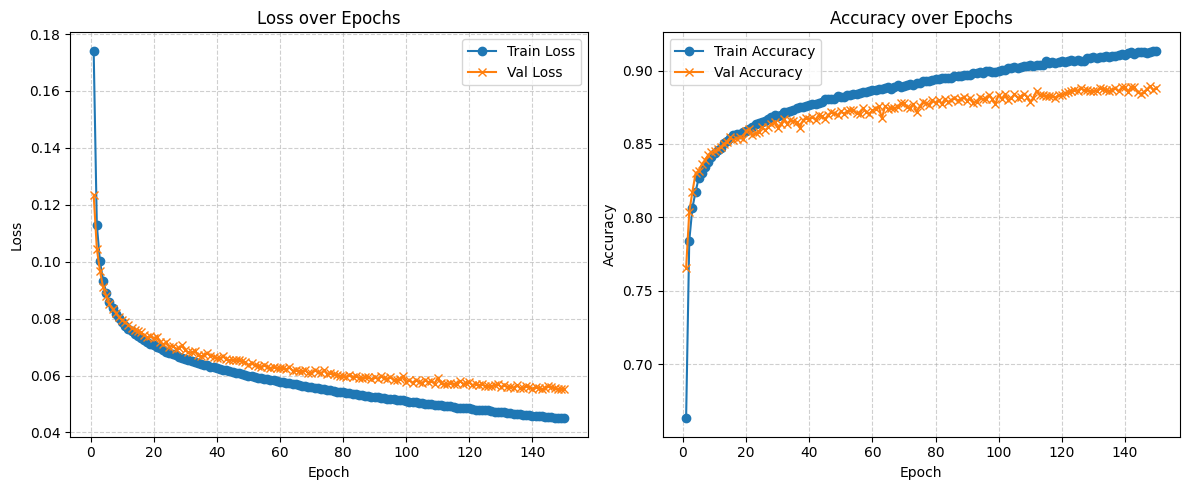

In [19]:
# Train

layer_sizes = [784, 128, 10]

params, history = train(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    layer_sizes=layer_sizes,
    epochs=150,
    batch_size=32,
    learning_rate=0.01,
    init_method='he',
    loss_name='bce',
    optimizer='momentum'
)

plot_training_history(history)

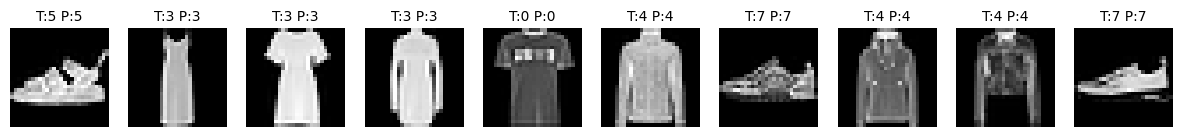

In [20]:
# Check predictions made

import matplotlib.pyplot as plt
import numpy as np

def predict(X, params):
    """
    Forward pass to get predictions.
    Returns:
        preds: predicted class indices
        probs: softmax probabilities
    """
    _, acts = forward_flexible(X, params)
    probs = acts[-1]
    preds = np.argmax(probs, axis=1)
    return preds, probs


def show_predictions(X, y_true, y_pred, n=10):
    """
    Plot n random samples with true and predicted labels.
    """
    indices = np.random.choice(len(X), n, replace=False)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap="gray")
        plt.title(f"T:{y_true[idx]} P:{y_pred[idx]}", fontsize=10)
        plt.axis("off")
    plt.show()

y_pred, _ = predict(X_val, params)
y_true = np.argmax(y_val, axis=1)
show_predictions(X_val, y_true, y_pred, n=10)


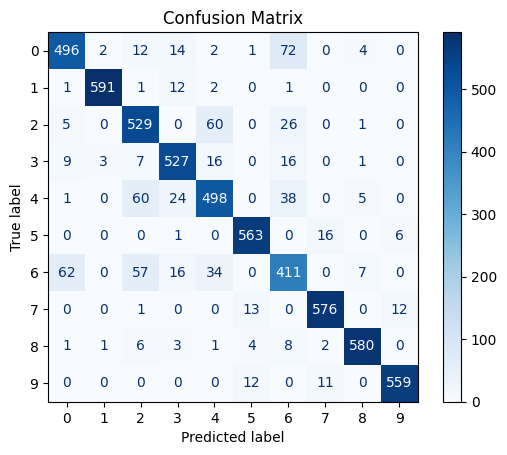

In [21]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


# WandB with MNIST Dataset

Track sweeps with MNIST to have different runs using different configurations of hyperparameters.
All steps from above are joined and implemented.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import wandb


# Load MNIST CSVs 
train_df = pd.read_csv("fashion-mnist_train.csv")
test_df  = pd.read_csv("fashion-mnist_test.csv")

# checks
print("Train rows:", len(train_df))
print("Train cols:", len(train_df.columns))
print("Test rows:", len(test_df))
print("Test cols:", len(test_df.columns))

# Extract labels
y_all = train_df.iloc[:, 0].to_numpy().astype(int)
X_all = train_df.iloc[:, 1:].to_numpy()
X_test = test_df.to_numpy()

# Normalize to [0,1]
X_all = X_all.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

print("Full training set:", X_all.shape, y_all.shape)
print("Test set:", X_test.shape)

# Train / Validation split
split_ratio = 0.9
n_total = len(X_all)
split_idx = int(n_total * split_ratio)

# Shuffle first
perm = np.random.permutation(n_total)
X_shuffled, y_shuffled = X_all[perm], y_all[perm]

# Split
X_train = X_shuffled[:split_idx]
y_train = y_shuffled[:split_idx]
X_val   = X_shuffled[split_idx:]
y_val   = y_shuffled[split_idx:]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

# One-hot encode labels
num_classes = len(np.unique(y_train))
y_train = np.eye(num_classes)[y_train]
y_val   = np.eye(num_classes)[y_val]

digit_labels = [str(i) for i in range(10)]
# show a few samples 
for i in range(5):
    print(f"sample {i}: original label {y_shuffled[i]} -> one-hot example {y_train[i][:10]}")


# activations, loss, etc.
def get_batch(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

def relu(x): return np.maximum(x, 0)
def relu_derivative(x): return np.where(x > 0, 1, 0)
def tanh(x): return np.tanh(x)
def tanh_derivative(x): return 1 - np.tanh(x)**2

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def apply_dropout(a, dropout_rate):
    if dropout_rate <= 0: return a, np.ones_like(a)
    mask = (np.random.rand(*a.shape) > dropout_rate).astype(np.float32)
    return a * mask / (1 - dropout_rate), mask

def cross_entropy_loss(y_true, y_pred, eps=1e-12):
    y_pred_clipped = np.clip(y_pred, eps, 1 - eps)
    loss = -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))
    dA = (y_pred - y_true) / y_true.shape[0]
    return loss, dA

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))


# Parameter init / forward / backward / optimizers
def init_weights_flexible(layer_sizes, method='he'):
    params = []
    for i in range(len(layer_sizes) - 1):
        in_dim, out_dim = layer_sizes[i], layer_sizes[i + 1]
        if method == 'he':
            scale = np.sqrt(2. / in_dim)
        elif method == 'xavier':
            scale = np.sqrt(1. / in_dim)
        else:
            scale = 0.01
        W = np.random.randn(in_dim, out_dim) * scale
        b = np.zeros((1, out_dim))
        params.append((W, b))
    return params

def forward_flexible(X, params, activation='relu', dropout_rate=0.0, train=True):
    activations, pre_acts, dropout_masks = [X], [], []
    for i, (W, b) in enumerate(params):
        z = activations[-1] @ W + b
        pre_acts.append(z)
        if i < len(params) - 1:
            if activation == 'relu':
                a = relu(z)
            elif activation == 'tanh':
                a = tanh(z)
            else:
                raise ValueError("Unsupported activation.")
            if train:
                a, mask = apply_dropout(a, dropout_rate)
            else:
                mask = np.ones_like(a)
            dropout_masks.append(mask)
        else:
            a = softmax(z)
            dropout_masks.append(np.ones_like(a))
        activations.append(a)
    return pre_acts, activations, dropout_masks

def backward_flexible(X, y, params, pre_acts, acts, dropout_masks, activation='relu', dA_last=None, l2_lambda=0.0):
    grads = [None] * len(params)
    m = X.shape[0]
    delta = dA_last if dA_last is not None else (acts[-1] - y)
    dW = acts[-2].T @ delta / m + l2_lambda * params[-1][0] / m
    db = np.sum(delta, axis=0, keepdims=True) / m
    grads[-1] = (dW, db)

    for l in reversed(range(len(params) - 1)):
        W_next, _ = params[l + 1]
        z = pre_acts[l]
        # propagate through next weight and apply dropout mask for that layer's activation
        delta = (delta @ W_next.T) * dropout_masks[l]
        if activation == 'relu':
            delta *= relu_derivative(z)
        elif activation == 'tanh':
            delta *= tanh_derivative(z)
        dW = acts[l].T @ delta / m + l2_lambda * params[l][0] / m
        db = np.sum(delta, axis=0, keepdims=True) / m
        grads[l] = (dW, db)
    return grads

def init_optimizer_states(params, optimizer='sgd'):
    if optimizer == 'momentum':
        v = [(np.zeros_like(W), np.zeros_like(b)) for W, b in params]
        return {'v': v}
    elif optimizer == 'adam':
        m = [(np.zeros_like(W), np.zeros_like(b)) for W, b in params]
        v = [(np.zeros_like(W), np.zeros_like(b)) for W, b in params]
        return {'m': m, 'v': v, 't': 0}
    return {}

def update_parameters_flexible(params, grads, lr, optimizer='sgd', opt_state=None,
                               beta1=0.9, beta2=0.999, eps=1e-8, momentum=0.9):
    new_params = []
    if optimizer == 'sgd':
        for (W, b), (dW, db) in zip(params, grads):
            W -= lr * dW; b -= lr * db
            new_params.append((W, b))
    elif optimizer == 'momentum':
        for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
            vW, vb = opt_state['v'][i]
            vW = momentum * vW - lr * dW
            vb = momentum * vb - lr * db
            W += vW; b += vb
            opt_state['v'][i] = (vW, vb)
            new_params.append((W, b))
    elif optimizer == 'adam':
        opt_state['t'] += 1; t = opt_state['t']
        for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
            mW, mb = opt_state['m'][i]; vW, vb = opt_state['v'][i]
            mW = beta1 * mW + (1 - beta1) * dW
            mb = beta1 * mb + (1 - beta1) * db
            vW = beta2 * vW + (1 - beta2) * (dW ** 2)
            vb = beta2 * vb + (1 - beta2) * (db ** 2)
            mW_hat = mW / (1 - beta1 ** t); mb_hat = mb / (1 - beta1 ** t)
            vW_hat = vW / (1 - beta2 ** t); vb_hat = vb / (1 - beta2 ** t)
            W -= lr * mW_hat / (np.sqrt(vW_hat) + eps)
            b -= lr * mb_hat / (np.sqrt(vb_hat) + eps)
            opt_state['m'][i] = (mW, mb); opt_state['v'][i] = (vW, vb)
            new_params.append((W, b))
    return new_params, opt_state


# W&B Sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'min': 0.0005, 'max': 0.1},
        'batch_size': {'values': [32, 64, 128, 256]},
        'optimizer': {'values': ['sgd', 'momentum', 'adam']},
        'init_method': {'values': ['he', 'xavier']},
        'hidden_layers': {'values': [[256, 128], [512, 256, 128], [512, 512, 256],[512, 256, 128, 64]]},
        'activation': {'values': ['relu', 'tanh']},
        'dropout_rate': {'values': [0.0, 0.1, 0.2, 0.3]},
        'l2_lambda': {'values': [0.0, 1e-4, 1e-3, 1e-2]},
        'epochs': {'values': [30, 50, 80, 100]}
    }
}


# W&B training function
def wandb_train():
    # Initialize run with sweep config parameters as the run's config
    wandb.init(project="fashion-mnist_project", config=sweep_config['parameters'])
    config = wandb.config

    # input size for MNIST is 784 (28x28)
    layer_sizes = [784] + config.hidden_layers + [10]
    params = init_weights_flexible(layer_sizes, method=config.init_method)
    opt_state = init_optimizer_states(params, config.optimizer)

    for epoch in range(config.epochs):
        # shuffle per epoch (y_train here is one-hot)
        perm = np.random.permutation(len(X_train))
        X_train_shuffled, y_train_shuffled = X_train[perm], y_train[perm]
        epoch_loss, epoch_acc = 0.0, 0.0
        num_batches = 0

        for X_batch, y_batch in get_batch(X_train_shuffled, y_train_shuffled, config.batch_size):
            pre_acts, acts, masks = forward_flexible(X_batch, params,
                                                     activation=config.activation,
                                                     dropout_rate=config.dropout_rate)
            y_pred = acts[-1]
            base_loss, dA = cross_entropy_loss(y_batch, y_pred)
            l2_loss = (config.l2_lambda / (2 * len(X_batch))) * sum(np.sum(W**2) for W, _ in params)
            total_loss = base_loss + l2_loss

            grads = backward_flexible(X_batch, y_batch, params, pre_acts, acts, masks,
                                      activation=config.activation, dA_last=dA, l2_lambda=config.l2_lambda)
            params, opt_state = update_parameters_flexible(params, grads, config.learning_rate,
                                                           optimizer=config.optimizer, opt_state=opt_state)

            epoch_loss += total_loss
            epoch_acc += accuracy(y_batch, y_pred)
            num_batches += 1

        # average over batches
        epoch_loss /= max(1, num_batches)
        epoch_acc /= max(1, num_batches)

        # Validation
        _, val_acts, _ = forward_flexible(X_val, params, activation=config.activation, dropout_rate=0.0, train=False)
        y_val_pred = val_acts[-1]
        val_loss, _ = cross_entropy_loss(y_val, y_val_pred)
        val_acc = accuracy(y_val, y_val_pred)

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_loss,
            'train_acc': epoch_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'l2_loss': l2_loss
        })

        print(f"Epoch {epoch+1}: train_loss={epoch_loss:.4f}, train_acc={epoch_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    # Log histograms of weights/biases
    for i, (W, b) in enumerate(params):
        wandb.log({f'W_layer_{i+1}': wandb.Histogram(W)})
        wandb.log({f'b_layer_{i+1}': wandb.Histogram(b)})

    # Save final params
    np.savez("final_params_fashion-mnist.npz", **{f"W{i}": W for i, (W, b) in enumerate(params)},
                                 **{f"b{i}": b for i, (W, b) in enumerate(params)})
    wandb.save("final_params_fashion-mnist.npz")
    wandb.finish()


# Start sweep
if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project="fashion-mnist_project")
    # run 30 random configs (adjust count or remove `count` to run indefinitely)
    wandb.agent(sweep_id, function=wandb_train, count=20)


Train rows: 60000
Train cols: 785
Test rows: 10000
Test cols: 785
Full training set: (60000, 784) (60000,)
Test set: (10000, 785)
Train set: (54000, 784), (54000,)
Validation set: (6000, 784), (6000,)
sample 0: original label 0 -> one-hot example [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sample 1: original label 3 -> one-hot example [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
sample 2: original label 2 -> one-hot example [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
sample 3: original label 3 -> one-hot example [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
sample 4: original label 3 -> one-hot example [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Create sweep with ID: hhwibfph
Sweep URL: https://wandb.ai/s243323-danmarks-tekniske-universitet-dtu/fashion-mnist_project/sweeps/hhwibfph


wandb: Agent Starting Run: 3eigaacc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 256, 128, 64]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.08250891840658119
wandb: 	optimizer: adam


Epoch 1: train_loss=2.6327, train_acc=0.1004, val_loss=2.3048, val_acc=0.0968
Epoch 2: train_loss=2.3119, train_acc=0.0992, val_loss=2.3053, val_acc=0.0940
Epoch 3: train_loss=2.3086, train_acc=0.1018, val_loss=2.3084, val_acc=0.0903
Epoch 4: train_loss=2.3084, train_acc=0.0996, val_loss=2.3065, val_acc=0.1013
Epoch 5: train_loss=2.3075, train_acc=0.0992, val_loss=2.3130, val_acc=0.0903
Epoch 6: train_loss=2.3078, train_acc=0.1008, val_loss=2.3051, val_acc=0.1047
Epoch 7: train_loss=2.3080, train_acc=0.1001, val_loss=2.3124, val_acc=0.1047
Epoch 8: train_loss=2.3085, train_acc=0.0998, val_loss=2.3066, val_acc=0.0940
Epoch 9: train_loss=2.3083, train_acc=0.0992, val_loss=2.3074, val_acc=0.1047
Epoch 10: train_loss=2.3077, train_acc=0.1011, val_loss=2.3050, val_acc=0.1047
Epoch 11: train_loss=2.3074, train_acc=0.0982, val_loss=2.3094, val_acc=0.1038
Epoch 12: train_loss=2.3087, train_acc=0.1002, val_loss=2.3034, val_acc=0.1047
Epoch 13: train_loss=2.3078, train_acc=0.1007, val_loss=2.311

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
l2_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▃▇▄▃▆▆▆▄▆▄▄▄▆▂▃▅▅▂▅▅▅▃▄▅▄▃▄▇▄▂▄▅▆▄▄▆▄▁█▅
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▇▇▇▇▆▃▅▁▅█▃▃▁▆▅█▅▁▅▄▅█▄▄▄▇▅▅▂█▅▂▆▆▆▂▁▅▄▁
val_loss,▇▃▁▆▅▆▄▄▇▁▃▆▆▂▅▄▆▅██▆▃▅█▆▃▄▄▃▅▃▁▅▃▄▃▄▃▄▅
epoch,100
l2_loss,0.00012
train_acc,0.10071
train_loss,2.30718
val_acc,0.09033


wandb: Agent Starting Run: 8mu3z0sp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 50
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.009412882122495955
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.3600, train_acc=0.0855, val_loss=2.3308, val_acc=0.0683
Epoch 2: train_loss=2.3436, train_acc=0.0936, val_loss=2.3144, val_acc=0.0822
Epoch 3: train_loss=2.3292, train_acc=0.1039, val_loss=2.2985, val_acc=0.0943
Epoch 4: train_loss=2.3122, train_acc=0.1137, val_loss=2.2832, val_acc=0.1157
Epoch 5: train_loss=2.2975, train_acc=0.1292, val_loss=2.2683, val_acc=0.1353
Epoch 6: train_loss=2.2815, train_acc=0.1418, val_loss=2.2538, val_acc=0.1592
Epoch 7: train_loss=2.2688, train_acc=0.1526, val_loss=2.2397, val_acc=0.1823
Epoch 8: train_loss=2.2555, train_acc=0.1654, val_loss=2.2260, val_acc=0.2035
Epoch 9: train_loss=2.2414, train_acc=0.1782, val_loss=2.2126, val_acc=0.2260
Epoch 10: train_loss=2.2292, train_acc=0.1919, val_loss=2.1994, val_acc=0.2483
Epoch 11: train_loss=2.2147, train_acc=0.2086, val_loss=2.1866, val_acc=0.2685
Epoch 12: train_loss=2.2027, train_acc=0.2205, val_loss=2.1739, val_acc=0.2877
Epoch 13: train_loss=2.1906, train_acc=0.2328, val_loss=2.161

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
train_loss,███▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_acc,▁▁▁▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_loss,███▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
epoch,50
l2_loss,0
train_acc,0.50559
train_loss,1.82011
val_acc,0.57383


wandb: Agent Starting Run: dwgx4fv5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.049696011350415285
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.3319, train_acc=0.1224, val_loss=2.1523, val_acc=0.2083
Epoch 2: train_loss=2.1397, train_acc=0.2121, val_loss=1.9642, val_acc=0.4390
Epoch 3: train_loss=1.9808, train_acc=0.3103, val_loss=1.8027, val_acc=0.5342
Epoch 4: train_loss=1.8435, train_acc=0.3867, val_loss=1.6614, val_acc=0.5845
Epoch 5: train_loss=1.7209, train_acc=0.4433, val_loss=1.5390, val_acc=0.6120
Epoch 6: train_loss=1.6124, train_acc=0.4880, val_loss=1.4345, val_acc=0.6308
Epoch 7: train_loss=1.5188, train_acc=0.5183, val_loss=1.3466, val_acc=0.6392
Epoch 8: train_loss=1.4398, train_acc=0.5434, val_loss=1.2723, val_acc=0.6465
Epoch 9: train_loss=1.3688, train_acc=0.5640, val_loss=1.2099, val_acc=0.6518
Epoch 10: train_loss=1.3081, train_acc=0.5780, val_loss=1.1569, val_acc=0.6570
Epoch 11: train_loss=1.2602, train_acc=0.5909, val_loss=1.1117, val_acc=0.6607
Epoch 12: train_loss=1.2134, train_acc=0.6025, val_loss=1.0726, val_acc=0.6650
Epoch 13: train_loss=1.1733, train_acc=0.6116, val_loss=1.038

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
l2_loss,▁▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_acc,▁▂▃▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
train_loss,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
l2_loss,0.00058
train_acc,0.77393
train_loss,0.6283
val_acc,0.799


wandb: Agent Starting Run: whtc3i8l with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 80
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.019984112104036965
wandb: 	optimizer: adam


Epoch 1: train_loss=1.2504, train_acc=0.5783, val_loss=0.7286, val_acc=0.7118
Epoch 2: train_loss=0.8727, train_acc=0.6658, val_loss=0.7834, val_acc=0.7028
Epoch 3: train_loss=0.8581, train_acc=0.6746, val_loss=0.6822, val_acc=0.7507
Epoch 4: train_loss=0.9022, train_acc=0.6563, val_loss=0.7427, val_acc=0.7283
Epoch 5: train_loss=0.8946, train_acc=0.6603, val_loss=0.7908, val_acc=0.6932
Epoch 6: train_loss=0.9223, train_acc=0.6442, val_loss=0.8619, val_acc=0.6772
Epoch 7: train_loss=0.8963, train_acc=0.6581, val_loss=0.6936, val_acc=0.7453
Epoch 8: train_loss=0.8994, train_acc=0.6596, val_loss=0.7422, val_acc=0.7462
Epoch 9: train_loss=0.8978, train_acc=0.6621, val_loss=0.7154, val_acc=0.7332
Epoch 10: train_loss=0.9262, train_acc=0.6452, val_loss=0.7832, val_acc=0.6945
Epoch 11: train_loss=0.8948, train_acc=0.6572, val_loss=0.7066, val_acc=0.7522
Epoch 12: train_loss=0.9051, train_acc=0.6564, val_loss=0.7240, val_acc=0.7313
Epoch 13: train_loss=0.9116, train_acc=0.6521, val_loss=0.702

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
l2_loss,█▄▂▄▂▂▁▂▁▂▂▂▂▂▂▃▁▃▁▂▁▂▁▂▁▂▂▂▂▂▁▁▃▂▂▁▁▂▁▂
train_acc,▁▇█▇▇▆▇▇▆▆▆▆▆▇▅▆▆▆▆▆▆▆▆▅▆▆▆▆▆▆▆▅▅▅▅▅▅▆▄▅
train_loss,▂▁▃▄▃▃▄▅▅▅▆▅▅▄▅▅▅▅▅▆▇▅▅▅▅▅▅▆▆▆▆▆▅▆▇█▇▆██
val_acc,▄▂▇▆▆▁▄▅▇█▇▄▇▆▇▆▃█▇▄▇▄▇▅▃▄▆▄▅▄▄▂▅▄▄▃▃▆▄▃
val_loss,▃▁▅█▁▅▂▄▅▃▄▅▂▄▄▂▂▃▂▂▃▄▁▄▄▅▆▄▃█▅▅▂▅▆▄▇▅▅▅
epoch,80
l2_loss,0.00087
train_acc,0.63081
train_loss,0.97295
val_acc,0.70067


wandb: Agent Starting Run: sw90kg9n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	hidden_layers: [512, 256, 128, 64]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.01843108545977194
wandb: 	optimizer: adam


Epoch 1: train_loss=1.0675, train_acc=0.5892, val_loss=0.7345, val_acc=0.7208
Epoch 2: train_loss=1.0096, train_acc=0.6153, val_loss=0.7752, val_acc=0.7075
Epoch 3: train_loss=1.0228, train_acc=0.6113, val_loss=0.7543, val_acc=0.7212
Epoch 4: train_loss=1.0261, train_acc=0.6110, val_loss=0.7492, val_acc=0.6912
Epoch 5: train_loss=1.0609, train_acc=0.5945, val_loss=0.8227, val_acc=0.6825
Epoch 6: train_loss=1.0670, train_acc=0.5972, val_loss=0.8330, val_acc=0.6753
Epoch 7: train_loss=1.0709, train_acc=0.5893, val_loss=0.9921, val_acc=0.6205
Epoch 8: train_loss=1.0820, train_acc=0.5826, val_loss=0.7922, val_acc=0.6968
Epoch 9: train_loss=1.0764, train_acc=0.5853, val_loss=0.8508, val_acc=0.6688
Epoch 10: train_loss=1.0972, train_acc=0.5768, val_loss=0.8826, val_acc=0.6138
Epoch 11: train_loss=1.1144, train_acc=0.5669, val_loss=0.8325, val_acc=0.6820
Epoch 12: train_loss=1.1585, train_acc=0.5485, val_loss=0.8448, val_acc=0.6778
Epoch 13: train_loss=1.0823, train_acc=0.5864, val_loss=0.883

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
l2_loss,▁▅▇▇█▇▆▆▅▅▅▄▄▄▆▅▆▄▅▅▅▄▄▆▄▄▃▃▄▅▅▃▆▄▄▄▄▆▃▄
train_acc,▆███▆▆▅▅▄▃▅▅▅▅▃▃▅▄▄▅▄▄▂▃▂▃▄▃▃▃▂▂▁▂▄▂▃▃▄▂
train_loss,▃▁▁▂▃▃▄▃▄▅▄▄▄▄▆▄▅▄▄▅▅▅▅▆▆▄▅▅▆▆▇▇▇█▇▇█▆▇█
val_acc,█▇█▆▆▃▇▅▂▆▇▇▇▄▄▆▆▆▇▄▇▅▅▆▅▅▅▅▅▁▃▅▄▇▂▅▅▅▅▆
val_loss,▁▂▁▁▃▇▂▄▅▃▅▃▂▂▄▃▄▄▄▄▄▅▅▄▆▄▅▅▆▅█▅▆▃▆▄▆▆▆▄
epoch,50
l2_loss,0.0013
train_acc,0.5527
train_loss,1.18974
val_acc,0.68233


wandb: Agent Starting Run: g718wuw3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 80
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.07147370725099834
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.2993, train_acc=0.1462, val_loss=2.1982, val_acc=0.2345
Epoch 2: train_loss=2.2404, train_acc=0.1709, val_loss=2.1351, val_acc=0.2885
Epoch 3: train_loss=2.1845, train_acc=0.2000, val_loss=2.0774, val_acc=0.3410
Epoch 4: train_loss=2.1401, train_acc=0.2213, val_loss=2.0238, val_acc=0.4023
Epoch 5: train_loss=2.0908, train_acc=0.2522, val_loss=1.9732, val_acc=0.4498
Epoch 6: train_loss=2.0474, train_acc=0.2760, val_loss=1.9251, val_acc=0.4877
Epoch 7: train_loss=2.0053, train_acc=0.2995, val_loss=1.8792, val_acc=0.5168
Epoch 8: train_loss=1.9638, train_acc=0.3236, val_loss=1.8353, val_acc=0.5400
Epoch 9: train_loss=1.9237, train_acc=0.3473, val_loss=1.7931, val_acc=0.5560
Epoch 10: train_loss=1.8858, train_acc=0.3629, val_loss=1.7526, val_acc=0.5698
Epoch 11: train_loss=1.8505, train_acc=0.3819, val_loss=1.7137, val_acc=0.5772
Epoch 12: train_loss=1.8123, train_acc=0.4005, val_loss=1.6765, val_acc=0.5858
Epoch 13: train_loss=1.7779, train_acc=0.4193, val_loss=1.640

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▃▃▃▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_loss,██▇▇▇▆▆▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
val_loss,█▇▇▇▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,80
l2_loss,0
train_acc,0.66037
train_loss,0.96485
val_acc,0.69917


wandb: Agent Starting Run: 1jqa06oy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	epochs: 30
wandb: 	hidden_layers: [512, 256, 128, 64]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.05466837843016305
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.2170, train_acc=0.2790, val_loss=1.9960, val_acc=0.4520
Epoch 2: train_loss=1.9071, train_acc=0.5135, val_loss=1.7485, val_acc=0.5690
Epoch 3: train_loss=1.6978, train_acc=0.5766, val_loss=1.5685, val_acc=0.5988
Epoch 4: train_loss=1.5422, train_acc=0.5957, val_loss=1.4341, val_acc=0.6102
Epoch 5: train_loss=1.4250, train_acc=0.6100, val_loss=1.3316, val_acc=0.6260
Epoch 6: train_loss=1.3344, train_acc=0.6284, val_loss=1.2509, val_acc=0.6422
Epoch 7: train_loss=1.2620, train_acc=0.6454, val_loss=1.1859, val_acc=0.6608
Epoch 8: train_loss=1.2028, train_acc=0.6615, val_loss=1.1320, val_acc=0.6747
Epoch 9: train_loss=1.1532, train_acc=0.6738, val_loss=1.0865, val_acc=0.6837
Epoch 10: train_loss=1.1110, train_acc=0.6846, val_loss=1.0474, val_acc=0.6923
Epoch 11: train_loss=1.0744, train_acc=0.6924, val_loss=1.0135, val_acc=0.7035
Epoch 12: train_loss=1.0425, train_acc=0.6989, val_loss=0.9836, val_acc=0.7098
Epoch 13: train_loss=1.0142, train_acc=0.7055, val_loss=0.956

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train_acc,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
val_loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
l2_loss,0.03959
train_acc,0.76402
train_loss,0.77322
val_acc,0.77233


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 72pu7vyt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	epochs: 50
wandb: 	hidden_layers: [512, 256, 128, 64]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.06221219904795575
wandb: 	optimizer: momentum


Epoch 1: train_loss=0.6071, train_acc=0.7981, val_loss=0.4331, val_acc=0.8507
Epoch 2: train_loss=0.4427, train_acc=0.8522, val_loss=0.3952, val_acc=0.8595
Epoch 3: train_loss=0.3960, train_acc=0.8666, val_loss=0.3634, val_acc=0.8715
Epoch 4: train_loss=0.3702, train_acc=0.8741, val_loss=0.3469, val_acc=0.8738
Epoch 5: train_loss=0.3518, train_acc=0.8802, val_loss=0.3297, val_acc=0.8793
Epoch 6: train_loss=0.3353, train_acc=0.8855, val_loss=0.3241, val_acc=0.8858
Epoch 7: train_loss=0.3204, train_acc=0.8911, val_loss=0.3290, val_acc=0.8832
Epoch 8: train_loss=0.3108, train_acc=0.8945, val_loss=0.3143, val_acc=0.8843
Epoch 9: train_loss=0.2999, train_acc=0.8965, val_loss=0.3060, val_acc=0.8902
Epoch 10: train_loss=0.2897, train_acc=0.9013, val_loss=0.3182, val_acc=0.8843
Epoch 11: train_loss=0.2819, train_acc=0.9026, val_loss=0.3179, val_acc=0.8863
Epoch 12: train_loss=0.2742, train_acc=0.9044, val_loss=0.3035, val_acc=0.8882
Epoch 13: train_loss=0.2669, train_acc=0.9068, val_loss=0.313

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
l2_loss,██▇▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▄▄▅▅▅▆▅▆▆▅▆▆▇▆▆▇▆▇▆█▇▇███▇▆▇▇██▇▇█▇█▇▅
val_loss,█▆▄▃▃▃▂▃▃▂▃▂▂▂▂▂▂▂▃▂▂▁▂▁▁▁▂▁▂▃▂▂▁▁▂▁▁▂▁▂
epoch,50
l2_loss,0.01084
train_acc,0.94329
train_loss,0.16067
val_acc,0.88217


wandb: Agent Starting Run: lrt31lrm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	epochs: 80
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.05439988141886336
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.1187, train_acc=0.3690, val_loss=1.9076, val_acc=0.5443
Epoch 2: train_loss=1.6862, train_acc=0.5946, val_loss=1.4611, val_acc=0.6313
Epoch 3: train_loss=1.3065, train_acc=0.6502, val_loss=1.1609, val_acc=0.6628
Epoch 4: train_loss=1.0828, train_acc=0.6681, val_loss=1.0003, val_acc=0.6762
Epoch 5: train_loss=0.9586, train_acc=0.6846, val_loss=0.9059, val_acc=0.6987
Epoch 6: train_loss=0.8814, train_acc=0.6986, val_loss=0.8433, val_acc=0.7127
Epoch 7: train_loss=0.8280, train_acc=0.7135, val_loss=0.7987, val_acc=0.7258
Epoch 8: train_loss=0.7877, train_acc=0.7271, val_loss=0.7637, val_acc=0.7407
Epoch 9: train_loss=0.7556, train_acc=0.7391, val_loss=0.7356, val_acc=0.7483
Epoch 10: train_loss=0.7288, train_acc=0.7485, val_loss=0.7108, val_acc=0.7568
Epoch 11: train_loss=0.7057, train_acc=0.7575, val_loss=0.6894, val_acc=0.7678
Epoch 12: train_loss=0.6857, train_acc=0.7653, val_loss=0.6715, val_acc=0.7750
Epoch 13: train_loss=0.6676, train_acc=0.7719, val_loss=0.655

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
l2_loss,▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
train_acc,▁▃▃▄▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▇▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▄▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
val_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,80
l2_loss,0.00045
train_acc,0.85597
train_loss,0.41589
val_acc,0.85317


wandb: Agent Starting Run: 66751r5r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.08429044736712449
wandb: 	optimizer: adam


Epoch 1: train_loss=3.5783, train_acc=0.1079, val_loss=3.7240, val_acc=0.0965
Epoch 2: train_loss=3.5376, train_acc=0.0998, val_loss=3.0912, val_acc=0.0903
Epoch 3: train_loss=3.5177, train_acc=0.1015, val_loss=3.9850, val_acc=0.0940
Epoch 4: train_loss=3.5587, train_acc=0.0995, val_loss=5.9514, val_acc=0.0965
Epoch 5: train_loss=3.4925, train_acc=0.0999, val_loss=3.7094, val_acc=0.0903
Epoch 6: train_loss=3.5015, train_acc=0.1013, val_loss=3.9121, val_acc=0.0940
Epoch 7: train_loss=3.5427, train_acc=0.1016, val_loss=4.3809, val_acc=0.0940
Epoch 8: train_loss=3.5366, train_acc=0.0989, val_loss=4.4526, val_acc=0.0965
Epoch 9: train_loss=3.4743, train_acc=0.1001, val_loss=4.1911, val_acc=0.0903
Epoch 10: train_loss=3.5295, train_acc=0.1025, val_loss=3.4555, val_acc=0.1047
Epoch 11: train_loss=3.5574, train_acc=0.1015, val_loss=3.3748, val_acc=0.1008
Epoch 12: train_loss=3.5421, train_acc=0.0995, val_loss=4.0686, val_acc=0.1047
Epoch 13: train_loss=3.5949, train_acc=0.0988, val_loss=3.363

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,█▂▃▂▂▃▁▂▄▂▃▂▂▂▃▃▃▃▃▁▃▂▂▁▃▂▃▄▁▂▃▄▄▄▂▂▂▂▃▃
train_loss,▆▄▃▅▂▄▄▁▃▅▆▂▃▄▅▂▄▃▆▂▃▇▄▅▄▃▅▅█▆▄▃▄▄▄▃▇▂▄▄
val_acc,▁▂▃▁▂▃▁▇▅▇▅▂▄▂▁▂█▄▆▅█▅▇▁▁▅▅▅▄▅▃▄█▃▆▄▄▄▄▆
val_loss,▃▁▃█▃▄▄▂▂▄▂▃▂▂▂▁▂▁▇▅▂▇▂▂▇▇▂▂▁▇▃▇▂▂▂▅▂▄▁▂
epoch,50
l2_loss,0
train_acc,0.10173
train_loss,3.51782
val_acc,0.10367


wandb: Agent Starting Run: sr32e6q0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 80
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.05728143722813589
wandb: 	optimizer: adam


Epoch 1: train_loss=1.6324, train_acc=0.4084, val_loss=1.5302, val_acc=0.3785
Epoch 2: train_loss=1.7417, train_acc=0.3466, val_loss=1.3425, val_acc=0.4670
Epoch 3: train_loss=1.7296, train_acc=0.3526, val_loss=1.3488, val_acc=0.4983
Epoch 4: train_loss=1.6335, train_acc=0.3800, val_loss=1.6506, val_acc=0.3937
Epoch 5: train_loss=1.8298, train_acc=0.3285, val_loss=1.4944, val_acc=0.3697
Epoch 6: train_loss=1.7724, train_acc=0.3215, val_loss=1.3981, val_acc=0.3717
Epoch 7: train_loss=1.7136, train_acc=0.3204, val_loss=1.6853, val_acc=0.3332
Epoch 8: train_loss=1.8041, train_acc=0.3132, val_loss=1.2904, val_acc=0.4260
Epoch 9: train_loss=1.8120, train_acc=0.3096, val_loss=1.6572, val_acc=0.3392
Epoch 10: train_loss=1.8673, train_acc=0.2945, val_loss=1.4737, val_acc=0.4353
Epoch 11: train_loss=1.8522, train_acc=0.3029, val_loss=1.3435, val_acc=0.4240
Epoch 12: train_loss=1.7486, train_acc=0.3338, val_loss=1.4358, val_acc=0.3515
Epoch 13: train_loss=1.7223, train_acc=0.3402, val_loss=1.597

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,█▄▂▁▁▂▄▄▅▄▄▄▂▃▃▄▄▅▆▄▆▆▅▆▆▆▅▅▆▆▇▆▆▆▆▇▇▇▆▇
train_loss,▇▆▄▆█▅▄▆▇▄▅▅▃▄▅▅▆▅▃▃▄▄▂▃▃▂▃▄▃▂▃▂▁▂▃▃▂▂▁▃
val_acc,▇▃▃▃▄▅▂▂▁▅▄▃▁▅▄▄▄▃▄▅▂▅▃▃▇▆▅▆▄█▃▃▅▆█▅▇▅▇▅
val_loss,▄▂▂▅▅▃▄▅▃▄▂▂▂▅▃▄▂▃▂▂▂▃▃▁▄▁█▃▃▄▂▃▁▁▃▂▃▁▂▁
epoch,80
l2_loss,0
train_acc,0.39018
train_loss,1.5976
val_acc,0.446


wandb: Agent Starting Run: wc5ql30m with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.055589091646164414
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.0777, train_acc=0.3032, val_loss=1.6856, val_acc=0.6315
Epoch 2: train_loss=1.4473, train_acc=0.5603, val_loss=1.0743, val_acc=0.6582
Epoch 3: train_loss=1.0806, train_acc=0.6204, val_loss=0.8652, val_acc=0.6873
Epoch 4: train_loss=0.9307, train_acc=0.6612, val_loss=0.7796, val_acc=0.7088
Epoch 5: train_loss=0.8556, train_acc=0.6875, val_loss=0.7282, val_acc=0.7322
Epoch 6: train_loss=0.8040, train_acc=0.7103, val_loss=0.6916, val_acc=0.7513
Epoch 7: train_loss=0.7642, train_acc=0.7268, val_loss=0.6587, val_acc=0.7700
Epoch 8: train_loss=0.7307, train_acc=0.7410, val_loss=0.6342, val_acc=0.7795
Epoch 9: train_loss=0.7026, train_acc=0.7525, val_loss=0.6145, val_acc=0.7875
Epoch 10: train_loss=0.6788, train_acc=0.7622, val_loss=0.5950, val_acc=0.7958
Epoch 11: train_loss=0.6583, train_acc=0.7693, val_loss=0.5808, val_acc=0.7987
Epoch 12: train_loss=0.6405, train_acc=0.7767, val_loss=0.5662, val_acc=0.8043
Epoch 13: train_loss=0.6279, train_acc=0.7783, val_loss=0.551

epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_loss,█▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
l2_loss,0
train_acc,0.87276
train_loss,0.3588
val_acc,0.8755


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zv3g1eex with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.06722530616629704
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.1486, train_acc=0.2224, val_loss=1.9302, val_acc=0.4840
Epoch 2: train_loss=1.8319, train_acc=0.4240, val_loss=1.5824, val_acc=0.6260
Epoch 3: train_loss=1.5491, train_acc=0.5142, val_loss=1.3158, val_acc=0.6530
Epoch 4: train_loss=1.3573, train_acc=0.5528, val_loss=1.1446, val_acc=0.6645
Epoch 5: train_loss=1.2267, train_acc=0.5826, val_loss=1.0311, val_acc=0.6732
Epoch 6: train_loss=1.1370, train_acc=0.6025, val_loss=0.9537, val_acc=0.6832
Epoch 7: train_loss=1.0647, train_acc=0.6231, val_loss=0.8978, val_acc=0.6888
Epoch 8: train_loss=1.0158, train_acc=0.6359, val_loss=0.8560, val_acc=0.6982
Epoch 9: train_loss=0.9784, train_acc=0.6490, val_loss=0.8240, val_acc=0.7075
Epoch 10: train_loss=0.9392, train_acc=0.6624, val_loss=0.7976, val_acc=0.7152
Epoch 11: train_loss=0.9148, train_acc=0.6695, val_loss=0.7761, val_acc=0.7230
Epoch 12: train_loss=0.8871, train_acc=0.6812, val_loss=0.7581, val_acc=0.7263
Epoch 13: train_loss=0.8694, train_acc=0.6860, val_loss=0.740

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
train_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████████
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
l2_loss,0
train_acc,0.79493
train_loss,0.59047
val_acc,0.82517


wandb: Agent Starting Run: 1p25kv9t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	epochs: 80
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.05556689139639369
wandb: 	optimizer: adam


Epoch 1: train_loss=3.0324, train_acc=0.1157, val_loss=2.7327, val_acc=0.0965
Epoch 2: train_loss=2.8448, train_acc=0.1034, val_loss=2.7924, val_acc=0.0940
Epoch 3: train_loss=2.8765, train_acc=0.1009, val_loss=2.9988, val_acc=0.0968
Epoch 4: train_loss=2.8367, train_acc=0.0988, val_loss=3.1431, val_acc=0.0965
Epoch 5: train_loss=2.8126, train_acc=0.0996, val_loss=3.3409, val_acc=0.1037
Epoch 6: train_loss=2.8595, train_acc=0.0999, val_loss=3.0118, val_acc=0.0940
Epoch 7: train_loss=2.8428, train_acc=0.0997, val_loss=3.1147, val_acc=0.1047
Epoch 8: train_loss=2.8500, train_acc=0.1016, val_loss=4.9394, val_acc=0.0903
Epoch 9: train_loss=2.8282, train_acc=0.0986, val_loss=2.9603, val_acc=0.0968
Epoch 10: train_loss=2.8108, train_acc=0.0992, val_loss=3.3637, val_acc=0.0968
Epoch 11: train_loss=2.8256, train_acc=0.1019, val_loss=3.3191, val_acc=0.1047
Epoch 12: train_loss=2.8699, train_acc=0.0991, val_loss=2.8364, val_acc=0.1037
Epoch 13: train_loss=2.8042, train_acc=0.1006, val_loss=2.949

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
l2_loss,▆▃▆▁▃▁▂▂▄▁▃▁▃█▁▃▂▂▄▂▂▄▃▃▃▂▄▃▃▄▁▂▂▃▄▂▁▁▂▁
train_acc,█▂▃▄▆▆▁▆▆▅▅▄▅▆▂▄▅▆▃▆▃▄▄▅▆▂▂▆▄▄▄▃▅▂▂▄▄▄▆▂
train_loss,█▂▃▃▂▂▁▃▁▄▃▂▃▄▂▃▂▂▂▃▂▃▁▂▂▄▂▃▃▃▂▂▂▂▃▃▄▃▄▄
val_acc,▃▄▃▇▁▄▇▆▆▂█▁▅▆▅▅▅▅▆▄▆▇▆▃▆▇▅▇▂▅▃▅▄▇▁▆▃▇▅▅
val_loss,▂▄▃▃▂▄▂▂▂▃▁▃▃▄▄▂▂▅▃▃▂▂▅▄▄▆█▁▄▂▅▃▃▅▅▃▂▃▅▁
epoch,80
l2_loss,0.03969
train_acc,0.10058
train_loss,2.88985
val_acc,0.10083


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5st5trjy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	hidden_layers: [512, 256, 128, 64]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.09363725475640244
wandb: 	optimizer: momentum


Epoch 1: train_loss=0.7347, train_acc=0.7458, val_loss=0.5056, val_acc=0.8178
Epoch 2: train_loss=0.5287, train_acc=0.8179, val_loss=0.4386, val_acc=0.8470
Epoch 3: train_loss=0.4935, train_acc=0.8291, val_loss=0.4206, val_acc=0.8470
Epoch 4: train_loss=0.4719, train_acc=0.8369, val_loss=0.4300, val_acc=0.8527
Epoch 5: train_loss=0.4599, train_acc=0.8409, val_loss=0.4330, val_acc=0.8490
Epoch 6: train_loss=0.4486, train_acc=0.8443, val_loss=0.4005, val_acc=0.8633
Epoch 7: train_loss=0.4426, train_acc=0.8453, val_loss=0.3965, val_acc=0.8598
Epoch 8: train_loss=0.4360, train_acc=0.8472, val_loss=0.3967, val_acc=0.8605
Epoch 9: train_loss=0.4268, train_acc=0.8509, val_loss=0.3896, val_acc=0.8633
Epoch 10: train_loss=0.4228, train_acc=0.8518, val_loss=0.3952, val_acc=0.8648
Epoch 11: train_loss=0.4205, train_acc=0.8524, val_loss=0.3879, val_acc=0.8647
Epoch 12: train_loss=0.4189, train_acc=0.8538, val_loss=0.4029, val_acc=0.8598
Epoch 13: train_loss=0.4151, train_acc=0.8545, val_loss=0.385

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
l2_loss,█▇▇▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▅▆▇▇▇▇▇▇▇██████████████████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▅▆▅▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█████▇▇▆█▇███
val_loss,█▅▄▄▄▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▂▂▂▁▂▂▂▁▁▃▁▁▂▁▁▁▁▁▁
epoch,50
l2_loss,0.00384
train_acc,0.8636
train_loss,0.38619
val_acc,0.86867


wandb: Agent Starting Run: 4ued3zr9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 80
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.04513319773362883
wandb: 	optimizer: adam


Epoch 1: train_loss=2.0012, train_acc=0.2132, val_loss=1.9171, val_acc=0.1653
Epoch 2: train_loss=1.9820, train_acc=0.1871, val_loss=2.0430, val_acc=0.1920
Epoch 3: train_loss=2.0989, train_acc=0.1664, val_loss=1.8666, val_acc=0.2078
Epoch 4: train_loss=2.0995, train_acc=0.1651, val_loss=1.9473, val_acc=0.2048
Epoch 5: train_loss=2.1922, train_acc=0.1359, val_loss=2.3169, val_acc=0.0903
Epoch 6: train_loss=2.3082, train_acc=0.1013, val_loss=2.3069, val_acc=0.1080
Epoch 7: train_loss=2.3088, train_acc=0.1005, val_loss=2.3118, val_acc=0.1037
Epoch 8: train_loss=2.3085, train_acc=0.1009, val_loss=2.3043, val_acc=0.1080
Epoch 9: train_loss=2.3084, train_acc=0.1001, val_loss=2.3051, val_acc=0.1080
Epoch 10: train_loss=2.3084, train_acc=0.1002, val_loss=2.3071, val_acc=0.1037
Epoch 11: train_loss=2.3081, train_acc=0.1011, val_loss=2.3106, val_acc=0.0965
Epoch 12: train_loss=2.3084, train_acc=0.1003, val_loss=2.3103, val_acc=0.1037
Epoch 13: train_loss=2.3085, train_acc=0.1015, val_loss=2.305

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
l2_loss,█▃▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▅█████████████████████████████████████
val_acc,▅▇██▁▂▂▁▁▁▂▁▁▁▁▁▁▁▂▂▁▂▂▂▁▂▂▂▁▁▂▁▂▁▁▂▂▁▂▁
val_loss,▄▁██████████████████████████████████████
epoch,80
l2_loss,1e-05
train_acc,0.09892
train_loss,2.30862
val_acc,0.094


wandb: Agent Starting Run: h346z56x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.05651451172317782
wandb: 	optimizer: momentum


Epoch 1: train_loss=1.2278, train_acc=0.5845, val_loss=0.7251, val_acc=0.7317
Epoch 2: train_loss=0.7149, train_acc=0.7460, val_loss=0.5945, val_acc=0.7922
Epoch 3: train_loss=0.6143, train_acc=0.7855, val_loss=0.5341, val_acc=0.8185
Epoch 4: train_loss=0.5560, train_acc=0.8067, val_loss=0.4954, val_acc=0.8307
Epoch 5: train_loss=0.5244, train_acc=0.8174, val_loss=0.4714, val_acc=0.8393
Epoch 6: train_loss=0.4984, train_acc=0.8264, val_loss=0.4521, val_acc=0.8470
Epoch 7: train_loss=0.4781, train_acc=0.8328, val_loss=0.4394, val_acc=0.8475
Epoch 8: train_loss=0.4617, train_acc=0.8380, val_loss=0.4293, val_acc=0.8512
Epoch 9: train_loss=0.4478, train_acc=0.8430, val_loss=0.4130, val_acc=0.8555
Epoch 10: train_loss=0.4342, train_acc=0.8464, val_loss=0.4108, val_acc=0.8568
Epoch 11: train_loss=0.4237, train_acc=0.8504, val_loss=0.3958, val_acc=0.8607
Epoch 12: train_loss=0.4139, train_acc=0.8540, val_loss=0.3855, val_acc=0.8645
Epoch 13: train_loss=0.4047, train_acc=0.8577, val_loss=0.382

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▇▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▃▅▆▆▆▇▇▇▇▇▇▇█▇█▇███████████████████████
val_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
l2_loss,0
train_acc,0.94442
train_loss,0.15237
val_acc,0.90433


wandb: Agent Starting Run: grulz7t3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0
wandb: 	epochs: 30
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.08310964326339848
wandb: 	optimizer: momentum


Epoch 1: train_loss=1.8009, train_acc=0.4961, val_loss=1.4577, val_acc=0.6288
Epoch 2: train_loss=1.3046, train_acc=0.6402, val_loss=1.1570, val_acc=0.6622
Epoch 3: train_loss=1.0928, train_acc=0.6684, val_loss=1.0085, val_acc=0.6863
Epoch 4: train_loss=0.9769, train_acc=0.6916, val_loss=0.9180, val_acc=0.7147
Epoch 5: train_loss=0.9020, train_acc=0.7140, val_loss=0.8566, val_acc=0.7260
Epoch 6: train_loss=0.8486, train_acc=0.7289, val_loss=0.8108, val_acc=0.7393
Epoch 7: train_loss=0.8079, train_acc=0.7397, val_loss=0.7752, val_acc=0.7508
Epoch 8: train_loss=0.7756, train_acc=0.7505, val_loss=0.7460, val_acc=0.7602
Epoch 9: train_loss=0.7491, train_acc=0.7580, val_loss=0.7222, val_acc=0.7668
Epoch 10: train_loss=0.7266, train_acc=0.7645, val_loss=0.7015, val_acc=0.7725
Epoch 11: train_loss=0.7075, train_acc=0.7709, val_loss=0.6844, val_acc=0.7783
Epoch 12: train_loss=0.6908, train_acc=0.7758, val_loss=0.6687, val_acc=0.7827
Epoch 13: train_loss=0.6761, train_acc=0.7806, val_loss=0.655

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
train_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
l2_loss,0.00597
train_acc,0.81634
train_loss,0.55637
val_acc,0.8215


wandb: Agent Starting Run: bnmn25h9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.04510234420088469
wandb: 	optimizer: adam


Epoch 1: train_loss=2.0637, train_acc=0.2839, val_loss=1.4922, val_acc=0.3733
Epoch 2: train_loss=1.5901, train_acc=0.3333, val_loss=1.3658, val_acc=0.4113
Epoch 3: train_loss=1.6050, train_acc=0.3320, val_loss=1.3739, val_acc=0.4263
Epoch 4: train_loss=1.6995, train_acc=0.3131, val_loss=1.4154, val_acc=0.3753
Epoch 5: train_loss=1.7363, train_acc=0.3079, val_loss=1.4073, val_acc=0.4333
Epoch 6: train_loss=1.7595, train_acc=0.2896, val_loss=1.4674, val_acc=0.3932
Epoch 7: train_loss=1.8146, train_acc=0.2457, val_loss=1.5512, val_acc=0.2955
Epoch 8: train_loss=1.7866, train_acc=0.2484, val_loss=1.5540, val_acc=0.2982
Epoch 9: train_loss=1.8568, train_acc=0.2458, val_loss=1.4563, val_acc=0.3627
Epoch 10: train_loss=1.7776, train_acc=0.2722, val_loss=1.5087, val_acc=0.3497
Epoch 11: train_loss=1.7614, train_acc=0.2754, val_loss=1.4576, val_acc=0.3625
Epoch 12: train_loss=1.7625, train_acc=0.2744, val_loss=1.5322, val_acc=0.3228
Epoch 13: train_loss=1.8015, train_acc=0.2552, val_loss=1.446

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███
l2_loss,█▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,█▇▇▇▅▅▆▆▅▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▃▃▄▃▃▃▄▅▄▄▄▅▄▄▅▅▄▅▄▄▄▄▅████████████████
val_acc,▇██▇▆▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁▂▂▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄████████████████████
epoch,100
l2_loss,0
train_acc,0.09899
train_loss,2.30603
val_acc,0.0965


wandb: Agent Starting Run: 4kg4eudb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.036106131761316405
wandb: 	optimizer: sgd


Epoch 1: train_loss=1.7289, train_acc=0.4550, val_loss=1.2145, val_acc=0.6613
Epoch 2: train_loss=1.1230, train_acc=0.6466, val_loss=0.9262, val_acc=0.7017
Epoch 3: train_loss=0.9318, train_acc=0.6882, val_loss=0.8087, val_acc=0.7298
Epoch 4: train_loss=0.8363, train_acc=0.7159, val_loss=0.7407, val_acc=0.7502
Epoch 5: train_loss=0.7775, train_acc=0.7317, val_loss=0.6944, val_acc=0.7623
Epoch 6: train_loss=0.7351, train_acc=0.7456, val_loss=0.6609, val_acc=0.7740
Epoch 7: train_loss=0.7035, train_acc=0.7565, val_loss=0.6337, val_acc=0.7817
Epoch 8: train_loss=0.6802, train_acc=0.7648, val_loss=0.6123, val_acc=0.7908
Epoch 9: train_loss=0.6583, train_acc=0.7719, val_loss=0.5945, val_acc=0.7988
Epoch 10: train_loss=0.6367, train_acc=0.7792, val_loss=0.5794, val_acc=0.8043
Epoch 11: train_loss=0.6230, train_acc=0.7848, val_loss=0.5668, val_acc=0.8063
Epoch 12: train_loss=0.6101, train_acc=0.7900, val_loss=0.5556, val_acc=0.8108
Epoch 13: train_loss=0.5984, train_acc=0.7926, val_loss=0.545

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,▆▇████████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁
train_acc,▁▅▅▆▆▇▇▇▇▇▇▇▇█████████████████
train_loss,█▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
l2_loss,0.01193
train_acc,0.82239
train_loss,0.51202
val_acc,0.83467
